# Projet data science - analyse initiale

Ce projet est construit selon l'approche [CRISP-ML](https://ml-ops.org/content/crisp-ml).

## Notre use case

Nous sommes Banklytics, une banque réputée en Amérique pour sa fiabilité.
Au-delà des services bancaires standards, nous sommes spécialisés dans les prêts hypothécaires.

Pour valider les hypothèques que nous proposons à nos clients, nous souhaitons estimer le prix de vente des maisons afin de nous assurer de la sureté de nos prêts. Plus particulièrement, nous souhaitons éviter de conclure de l'hypothèque au-dessus de la valeur du marché du bien. Cela afin de nous assurer de pouvoir revendre le bien sans pertes en cas de mauvais payeur.


Nous devons donc développer un modèle permettant de prédire la valeur du bien immobilier se basant sur les critères fournis afin de vérifier si le prix de vente se rapproche de la valeur du bien.

## Data & business understanding

Afin de décider si nous proposons un prêt ou non, nous souhaiterions disposer, en plus de nos analystes, d'un modèle qui peut estimer les prix des maisons sur la base de leurs caractéristiques principales, le plus précisément possible. Lorsque nos clients se présentent, ils nous transmettent tous le dossier technique de leur bien, nous souhaitons pouvoir rentrer les caractéristiques du bien dans notre système et obtenir l'estimation la plus précise possible du prix.

Pour valider la faisabilité, nous disposons d'un [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) pour la région d'Ames dans l'Iowa aux Etats-Unis. Le dataset s'étend de 2006 à 2010.

Bien que les données de ce dataset ne soient pas à jour, nous souhaitons l'utiliser pour valider qu'il est possible d'obtenir des prédictions suffisamment fiables. Si cela s'avère concluant, il serait nécessaire dans un second temps de construire un dataset plus moderne afin de valider la faisabilité du projet.

## Importation des données et des librairies

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

plt.style.use('seaborn-v0_8')

In [190]:
# Data loading
train_raw = pd.read_csv('train.csv', index_col = 'Id')
validation_raw = pd.read_csv('test.csv', index_col = 'Id')

## Fonctions diverses

Fonctions diverses utilisées au fil de l'analyse. Ce projet est inspiré des exemples et ressources fournies dans le carde du cours de data science : https://github.com/kiwil87/64-61.1-Data-Science

In [191]:
# Fill empty values with a constant to avoid NaN issues in calculations
def fill_missing_with_constant(data, columns, constant):
    
    data_clean = data.copy()
    
    for c in columns :
        
        if data_clean[c].isnull().any():
            data_clean[c] = data_clean[c].fillna(constant)
    
    return data_clean

In [192]:
def plot_missing(data):

    missing = data.isnull().sum()
    missing = missing[missing > 0]
    
    if missing.empty:
        print('No missing values')
    else :
        missing.sort_values(inplace=True)
        missing.plot.bar()
    
        plt.show()

In [193]:
# For date variables, we will fill the missing values using the values from another column
def fill_missing_with_column(data, missing, column) :
    
    data_clean = data.copy()
    
    data_clean[missing] = np.where(data_clean[missing].isnull(), data_clean[column], data_clean[missing])
    
    return data_clean

In [194]:
def compute_differences_to_year_sold(data) :
    
    data_clean = data.copy()
    
    data_clean['YearBuilt'] = data_clean['YrSold'] - data_clean['YearBuilt']
    data_clean['YearRemodAdd'] = data_clean['YrSold'] - data_clean['YearRemodAdd']
    data_clean['GarageYrBlt'] = data_clean['YrSold'] - data_clean['GarageYrBlt']
    
    return data_clean

In [195]:
def clean(data) :
    
    data_clean = data.copy()
    
    # imputing missing variables
    data_clean = fill_missing_with_constant(data_clean, columns = quantitative, constant = 0)
    data_clean = fill_missing_with_constant(data_clean, columns = qualitative, constant = 'NA')
    data_clean = fill_missing_with_column(data_clean, missing = ['GarageYrBlt'], column = ['YearBuilt'])

    # transform date columns
    data_clean = compute_differences_to_year_sold(data_clean)
    
    return data_clean

In [196]:
def correlation(y, X, features, method = 'pearson'):
    
    cor = pd.DataFrame()
    cor['feature'] = features
    
    cor['correlation_coef'] = [X[f].corr(y, method = method) for f in features]
    cor['correlation_coef'] = cor['correlation_coef'].fillna(0)
    
    cor = cor.sort_values('correlation_coef', ascending = False)

    plt.figure(figsize=(10, 0.25*len(features)))
    sns.barplot(data = cor, y = 'feature', x = 'correlation_coef', orient = 'h')
    
    return cor

In [197]:
def scatter_plots(y, X, features) :
    
    for f in features :
        x = X[f]
        
        plt.title('Correlation ' + y.name + ' & ' + x.name)
        sns.regplot(x = x.name, y = y.name, data = pd.concat([x, y], axis = 1), x_jitter = .05)
        
        plt.show()

In [198]:
def anova(y, X, features):
    
    anova = pd.DataFrame()
    anova['feature'] = features
    pvals = []
    
    for f in features:
        
        samples = []
        
        for cls in X[f].unique():
            
            s = y[X[f] == cls].values
            samples.append(s)
            
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
        
    anova['pval'] = pvals
    anova = anova.sort_values('pval')
    
    anova['disparity'] = np.log(1. / anova['pval'].values)

    sns.barplot(data = anova, x = 'feature', y = 'disparity')
    x = plt.xticks(rotation=90)
    
    return anova

In [199]:
def box_plots(y, X, features) :
    
    for f in features :
        x = X[f]
    
        plt.title('Box plot ' + y.name + ' & ' + x.name)
        sns.boxplot(x = x, y = y)
        x = plt.xticks(rotation = 90)
        
        plt.show()

In [200]:
def encode_with_mean(data, target, features):
    
    data_preprocess = data.copy()
    
    for f in features: 
        
        # create a temporary dataframe for our workload
        frame = pd.DataFrame()
        frame[f] = data[f].copy()
        frame[target.name] = target.copy()
        
        # create the mapping table
        mapping = pd.DataFrame()
        mapping['val'] = data[f].unique()
        mapping.index = mapping.val
        
        # compute the mean of our target variable for each category
        mapping['mean'] = frame[[f, target.name]].groupby(f).mean()[target.name]
        
        # if a category has NA, we shall simply put the mean value
        mapping['mean'] = mapping['mean'].fillna(target.mean())

        # we replace the feature with the means in the mapping table
        data_preprocess[f] = pd.merge(data_preprocess, mapping, left_on = f, right_index = True)['mean'].copy()
        
    return data_preprocess

In [201]:
from statsmodels.graphics.gofplots import ProbPlot
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
    """
    Function to reproduce the 4 base plots of an OLS model in R.

    ---
    Inputs:

    X: A numpy array or pandas dataframe of the features to use in building the linear regression model
    y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

    model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
    """

    if not model_fit:
        model_fit = sm.OLS(y, sm.add_constant(X)).fit()

    # create dataframe from X, y for easier plot handling
    dataframe = pd.concat([X, y], axis=1)
    
    # model values
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]
    
    plot_lm_1 = plt.figure()
    plot_lm_1.axes[0] = sns.residplot(x = model_fitted_y, y = dataframe.columns[-1], data = dataframe,
                                      lowess=True,
                                      scatter_kws={'alpha': 0.5},
                                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals');
    
    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_residuals[i]));
        
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
    
    plot_lm_3 = plt.figure()
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(x = model_fitted_y, y = model_norm_residuals_abs_sqrt,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel(r'$\sqrt{|Standardized Residuals|}$');
    
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i,
                                   xy=(model_fitted_y[i],
                                       model_norm_residuals_abs_sqrt[i]));
    
    plot_lm_4 = plt.figure();
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
    sns.regplot(x = model_leverage, y = model_norm_residuals,
                scatter=False,
                ci=False,
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
    plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals');
    
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i,
                                   xy=(model_leverage[i],
                                       model_norm_residuals[i]));
        
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50),
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
          np.linspace(0.001, max(model_leverage), 50)) # 1 line
    plot_lm_4.legend(loc='upper right');

In [202]:
def remove_outliers(data, target, feature):
    
    data_preprocess = data.copy()
    data_preprocess[target.name] = target.copy()
    
    #Compute interquartile range
    q1 = data_preprocess[feature].quantile(0.25)
    q3 = data_preprocess[feature].quantile(0.75)
    
    iqr = q3-q1 
    
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    
    data_preprocess = data_preprocess.loc[(data_preprocess[feature] > fence_low) & (data_preprocess[feature] < fence_high)]
    
    return data_preprocess[data.columns], data_preprocess[target.name]

In [203]:
def plot_prediction(actual, predicted) :
    
    data = pd.concat([actual, predicted], keys = ['actual', 'predicted'], axis = 1)

    plt.title('Actual vs Predicted')
    sns.regplot(x = 'actual', y = 'predicted', data = data)
    plt.show()

In [204]:
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted) :
    return np.sqrt(mean_squared_error(actual, predicted))




### Variables choices

## Baseline model engineering


In [205]:
train_raw['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

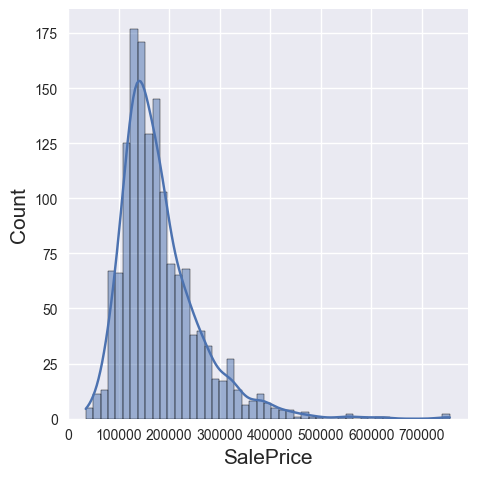

In [206]:
# distribution plot with normal fit
ax = sns.displot(data = train_raw['SalePrice'], kde=True)
plt.show()

The assocated p-value is : 3.2061412312021656e-33
With a threshold α = 0.05, we reject the null hypothesis


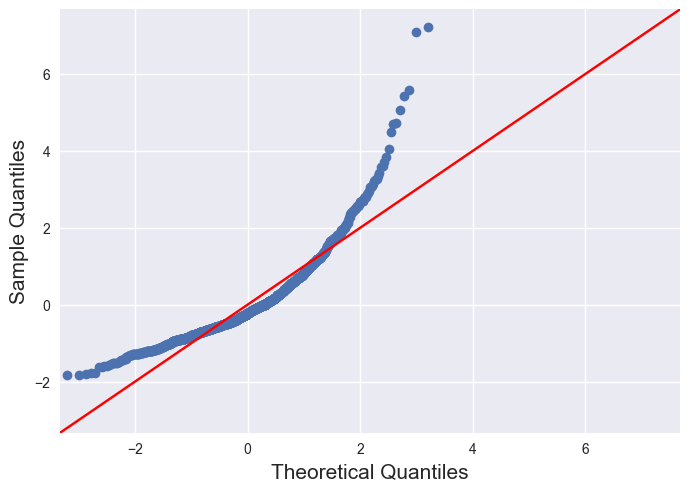

In [207]:
# Shapiro-Wilk Test for normality together with the Q-Q plot
alpha = 0.05
W, p = stats.shapiro(train_raw['SalePrice'])

print('The assocated p-value is : ' + str(p))

if p < alpha : 
    print('With a threshold α = ' + str(alpha) + ', we reject the null hypothesis')
else : 
    print('With a threshold α = ' + str(alpha) + ', we fail to reject the null hypothesis')
    
qqplot(train_raw['SalePrice'], dist = stats.distributions.norm, fit = True, line = '45')
plt.show()

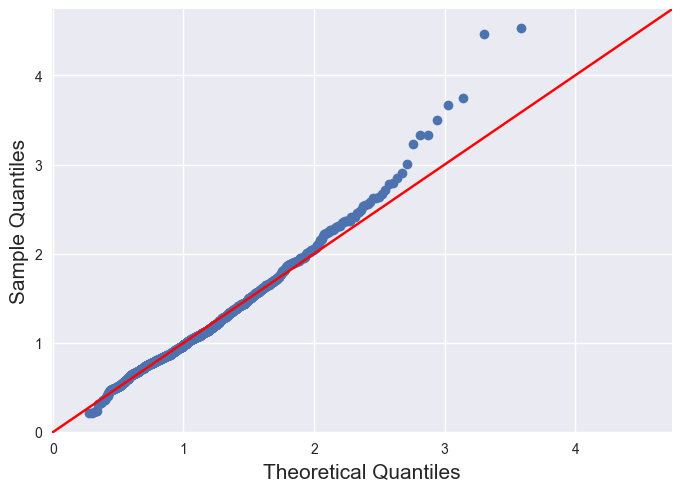

In [208]:
qqplot(train_raw['SalePrice'], dist = stats.distributions.lognorm, fit = True, line = '45')
plt.show()

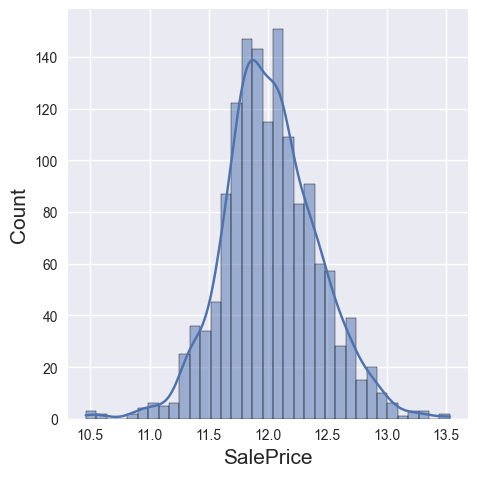

In [209]:
# new variable target which is the logarithm of the SalePrice
target = np.log1p(train_raw['SalePrice'])

# distribution plot
ax = sns.displot(data = target, kde=True)
plt.show()

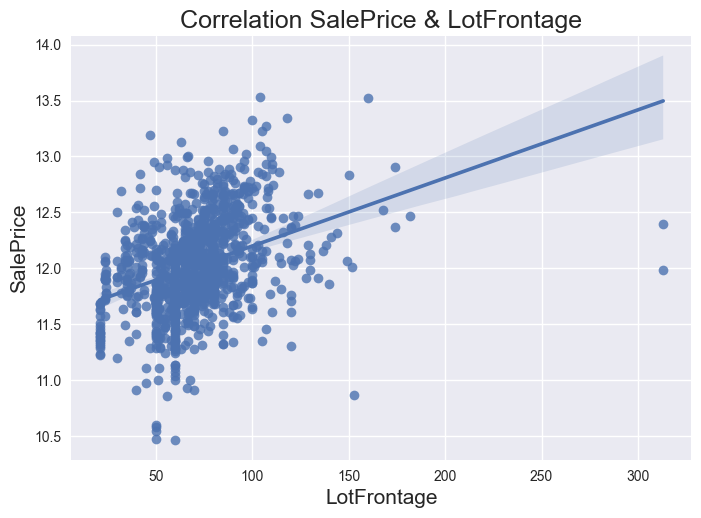

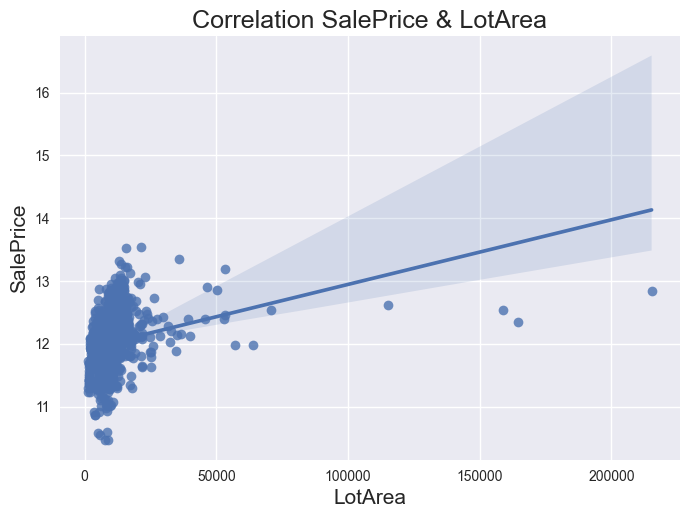

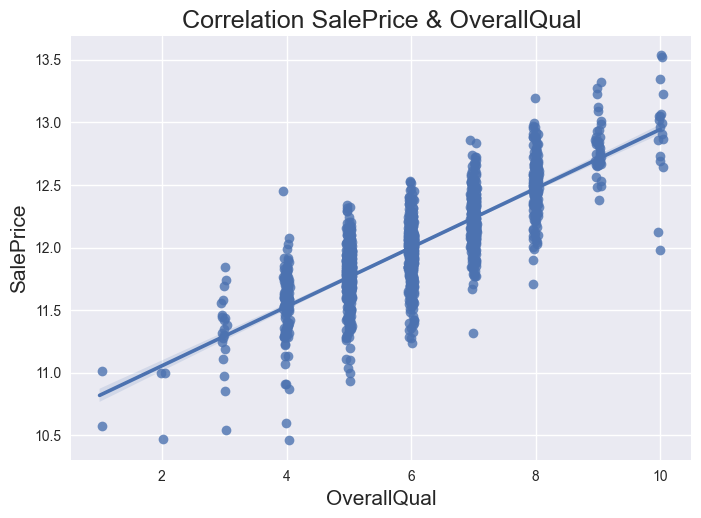

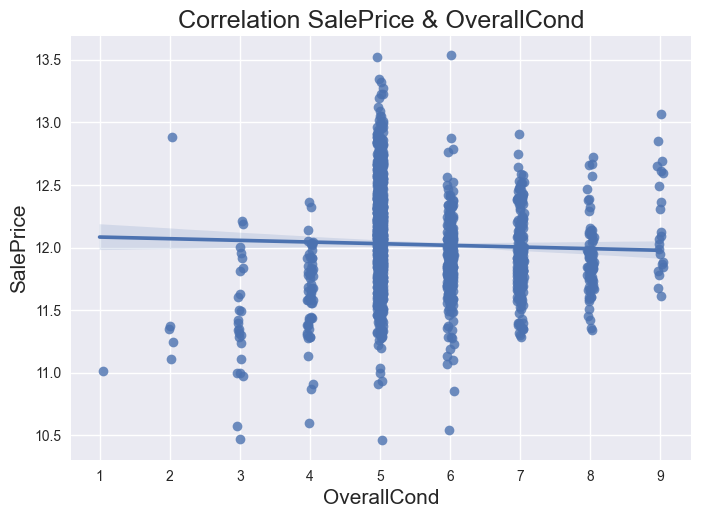

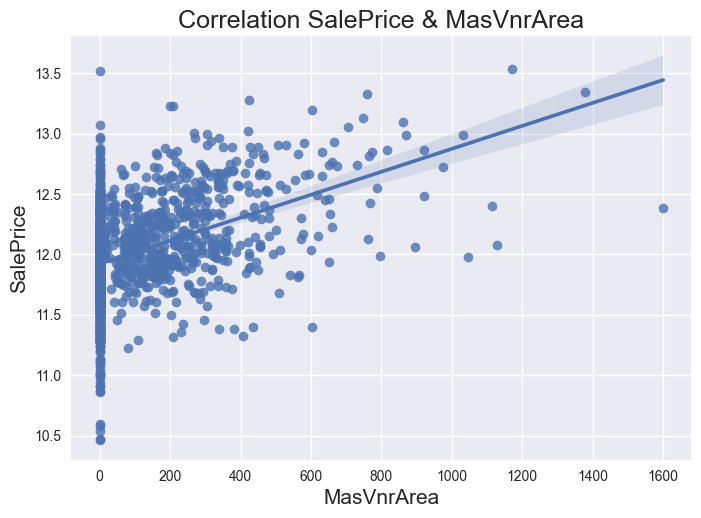

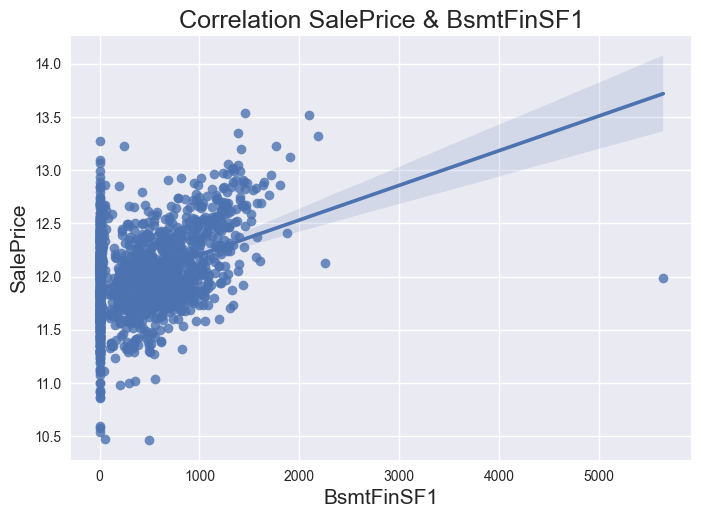

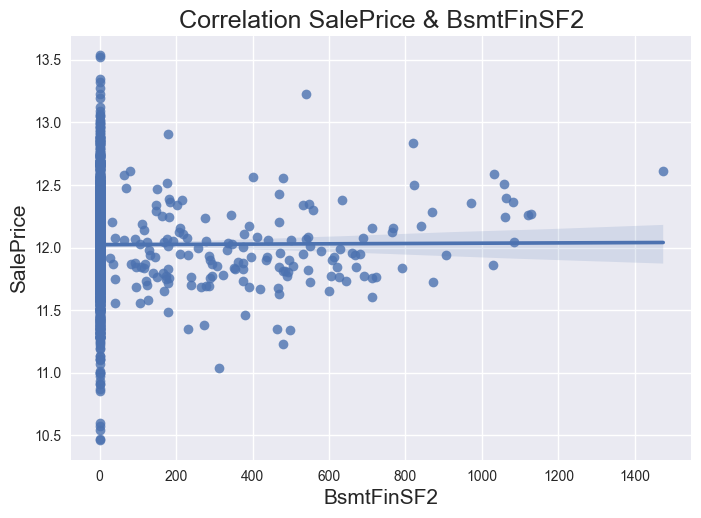

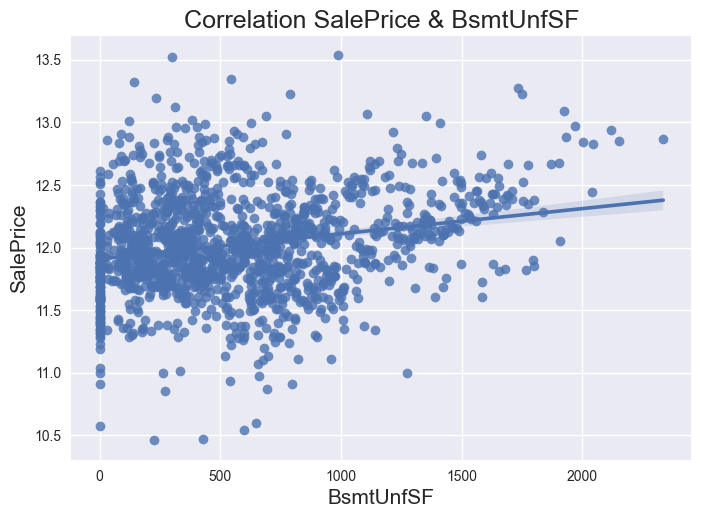

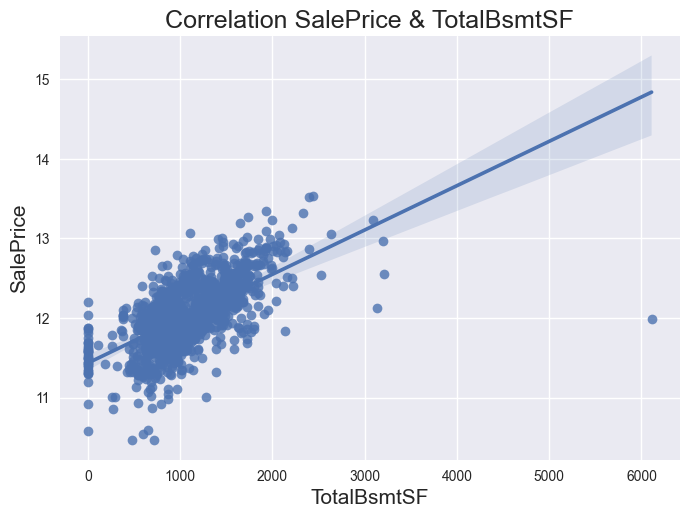

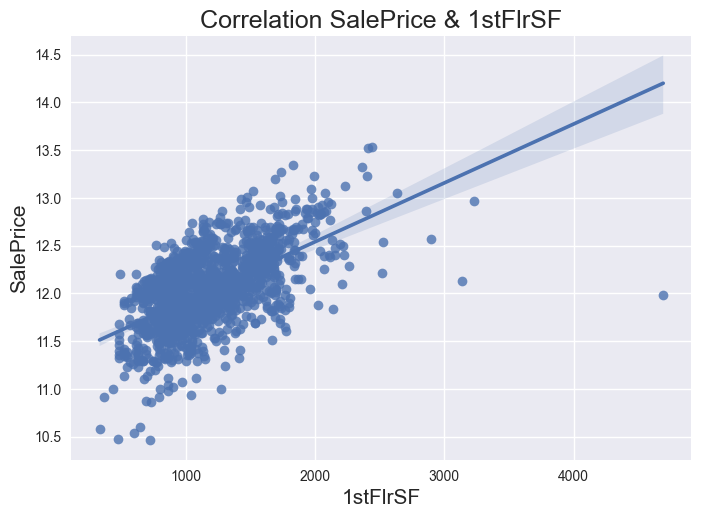

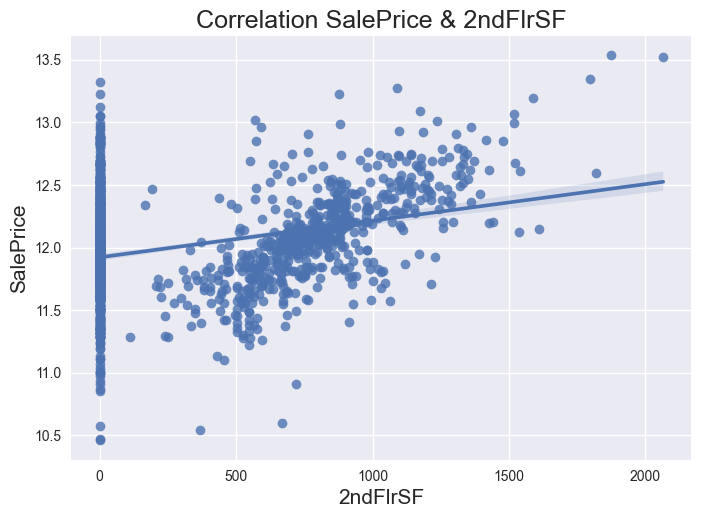

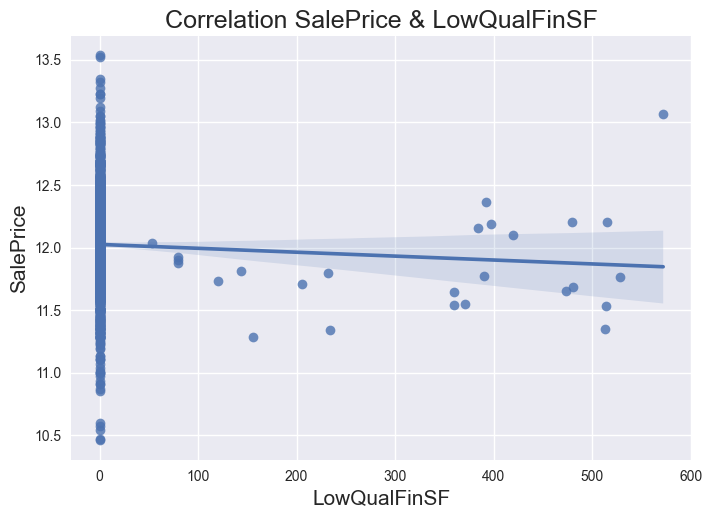

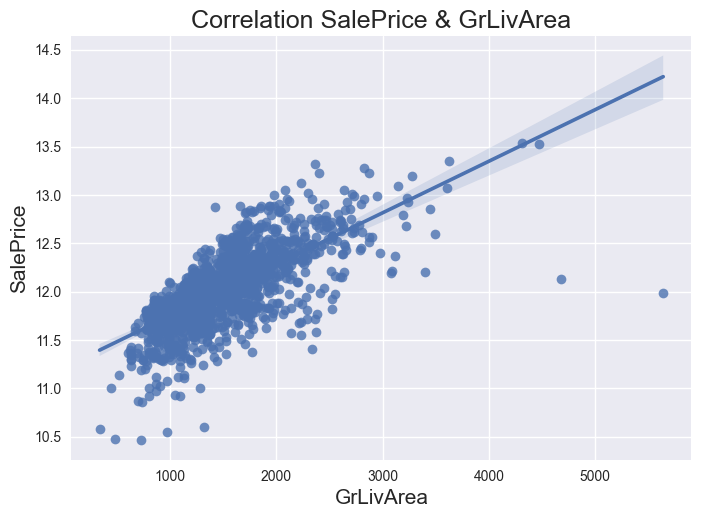

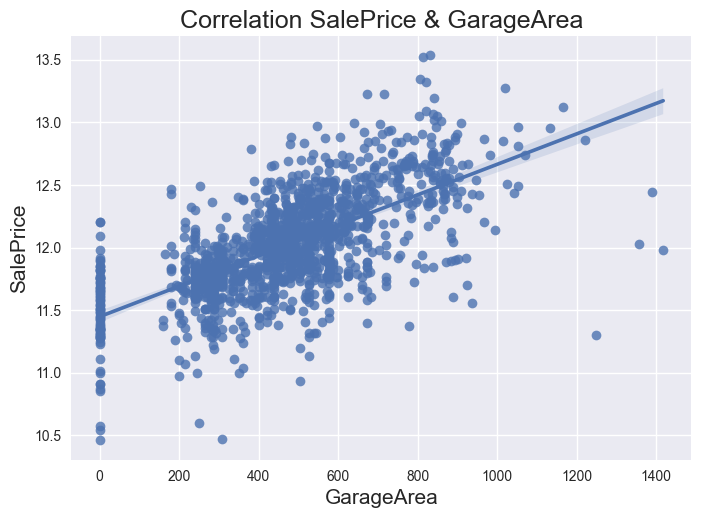

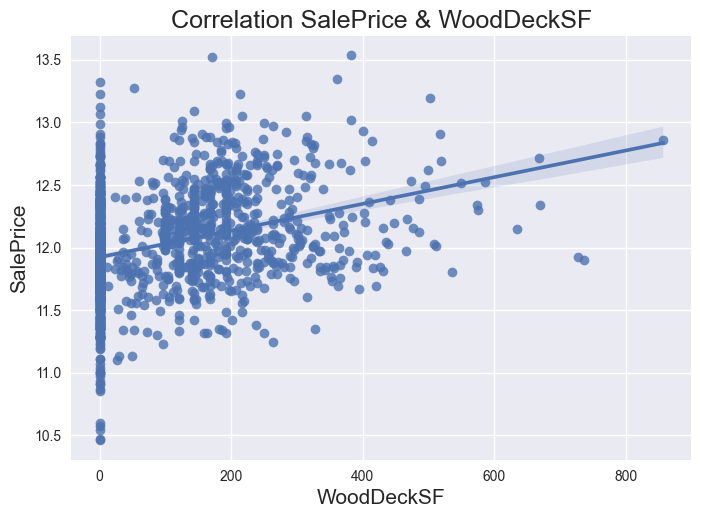

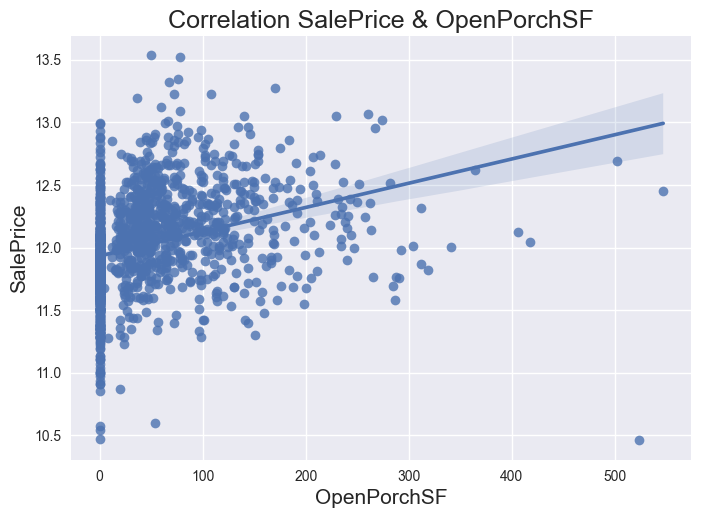

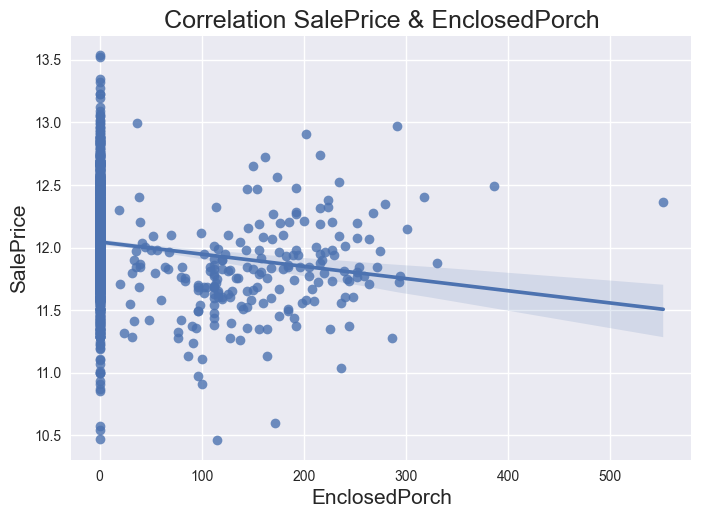

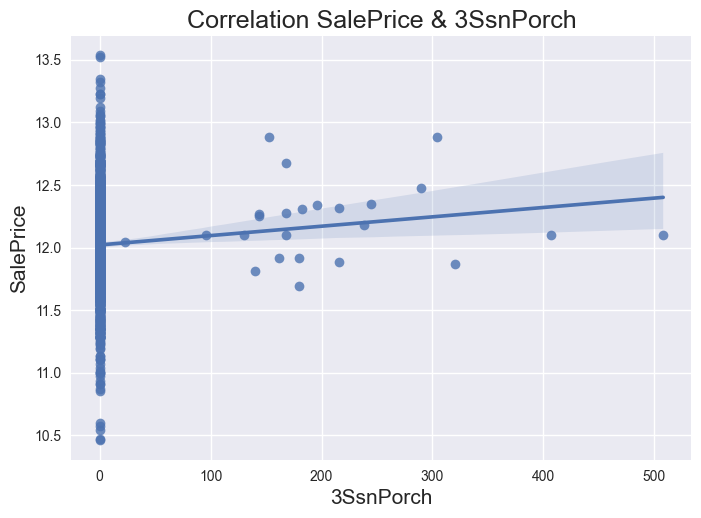

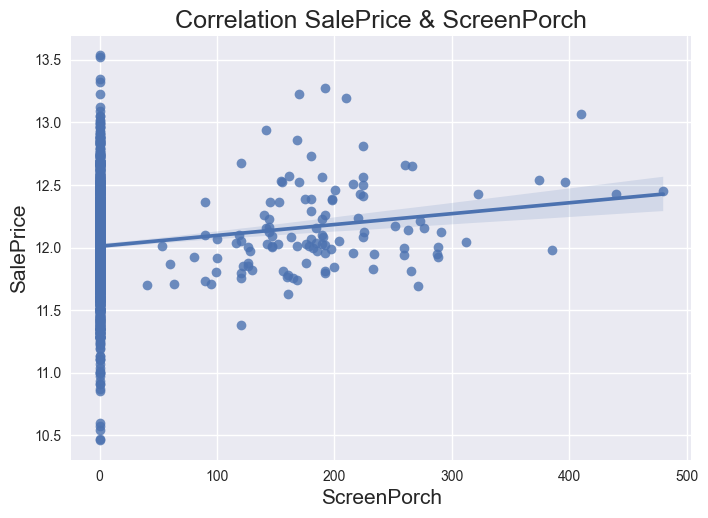

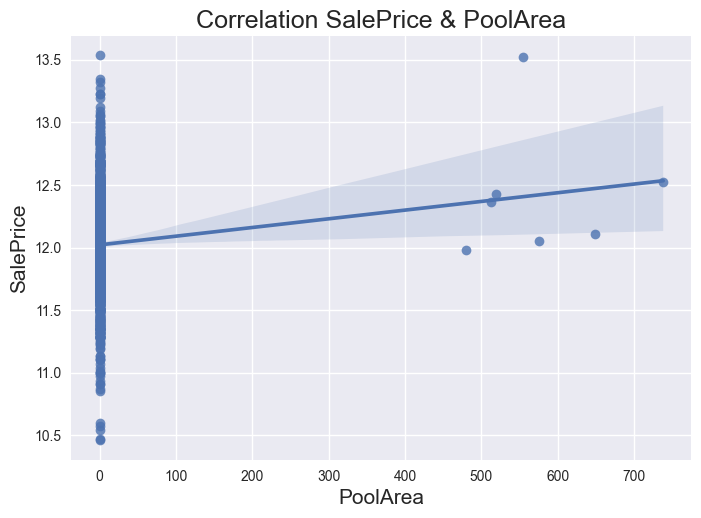

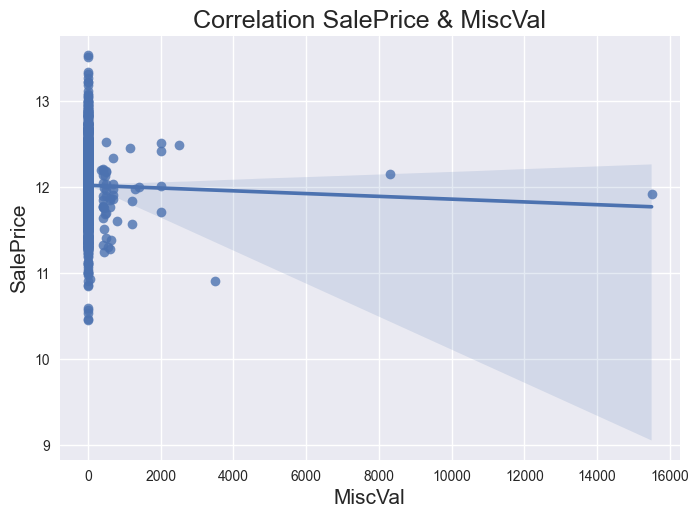

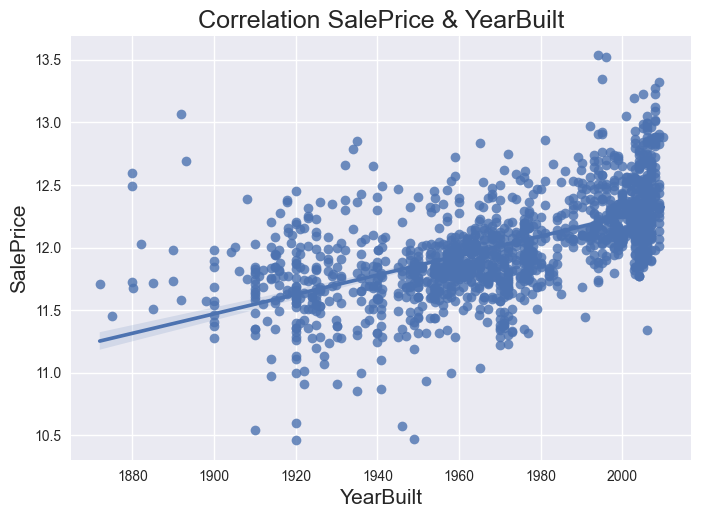

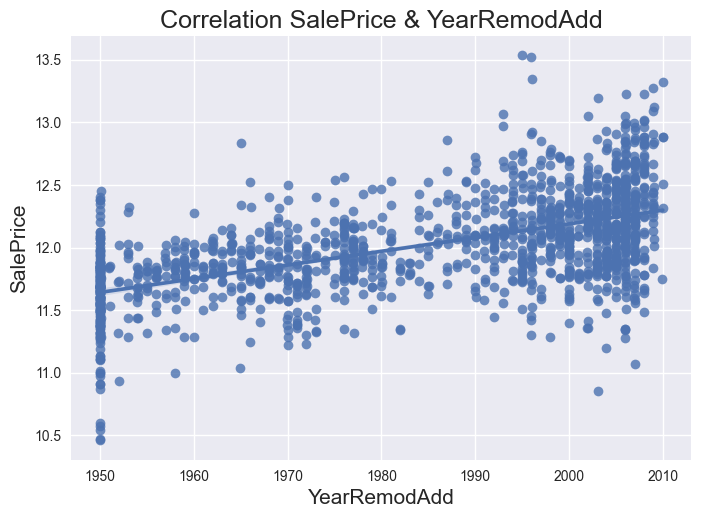

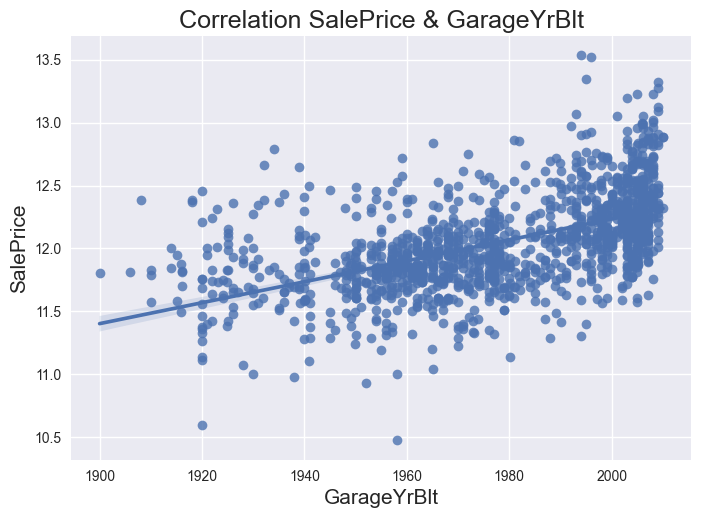

In [210]:
scatter_plots(target, train_raw, numeric)

C:\Users\david\AppData\Local\Temp\ipykernel_39728\1467523942.py:16: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  pval = stats.f_oneway(*samples)[1]


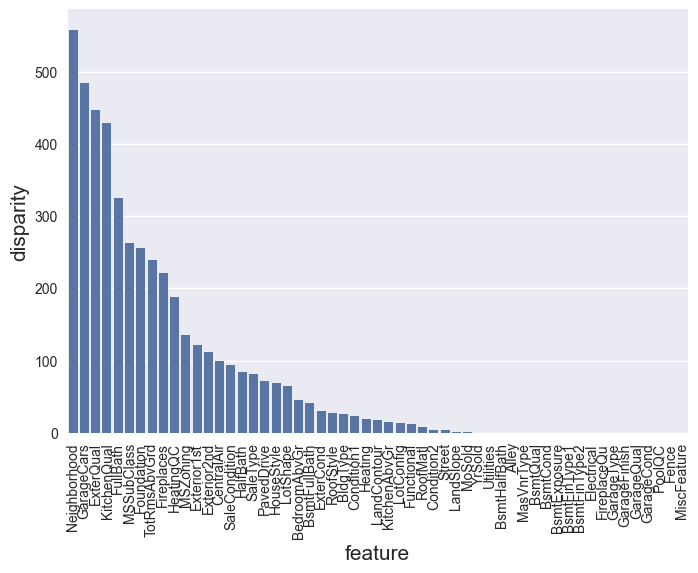

In [211]:
anova = anova(target, train_raw, categorical)

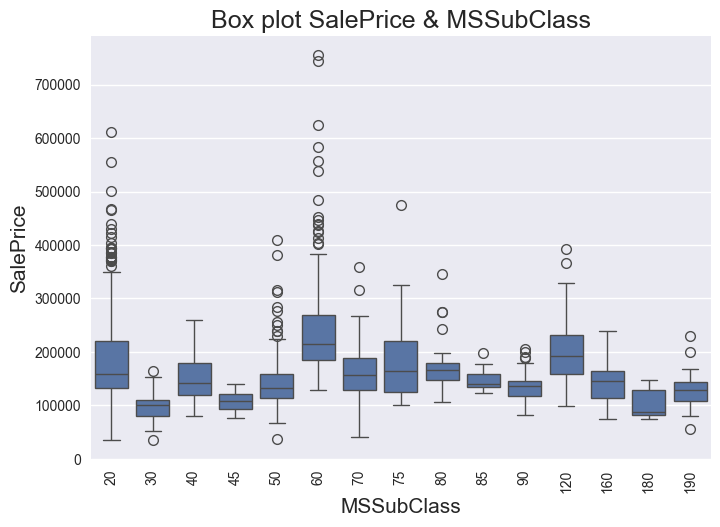

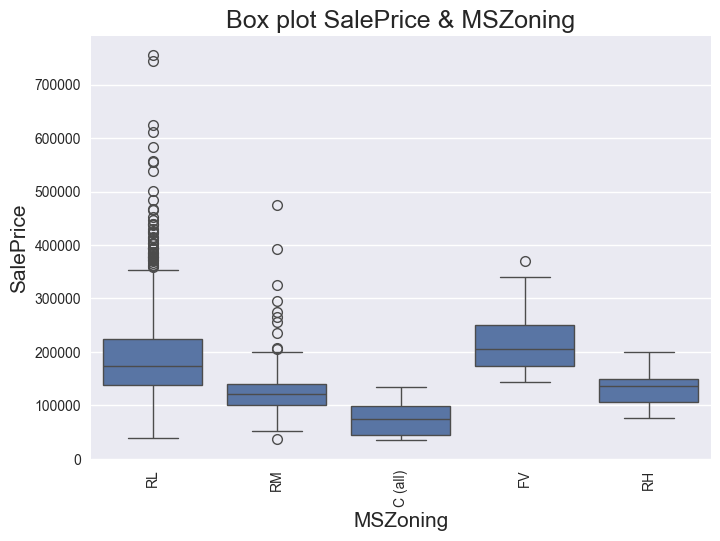

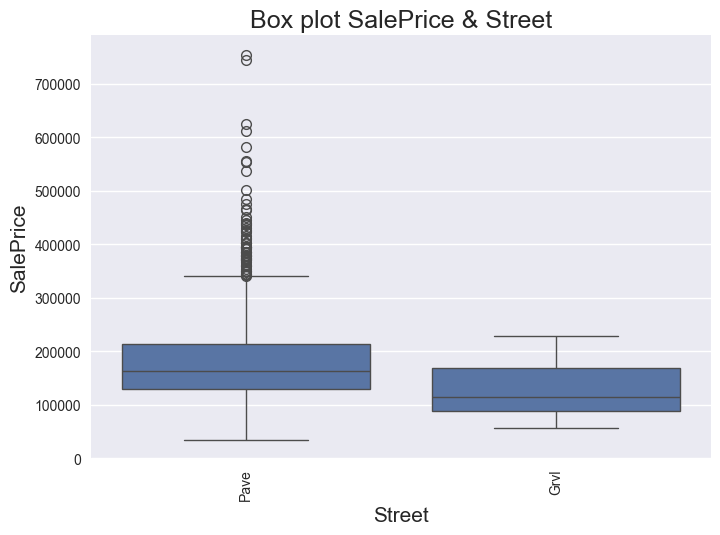

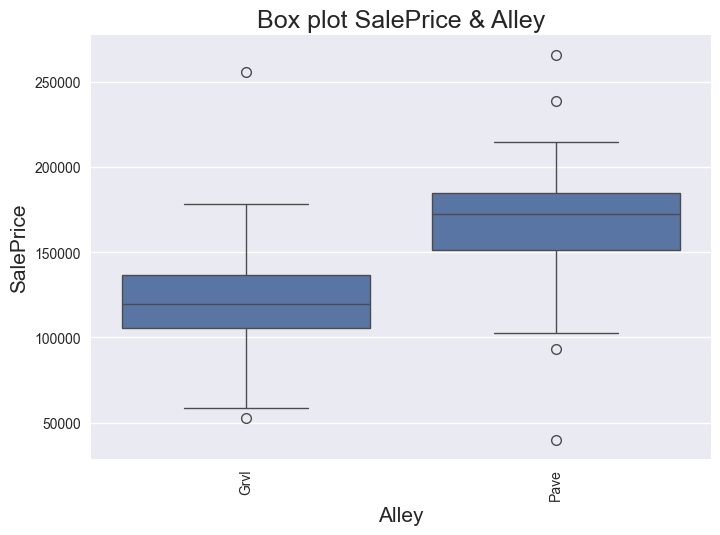

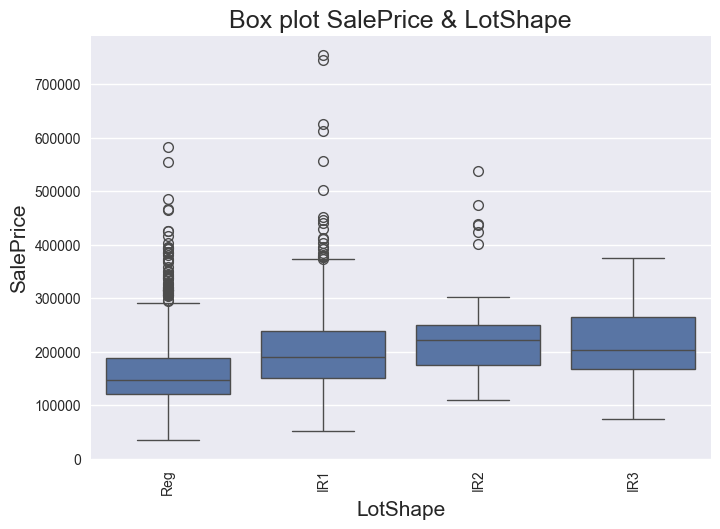

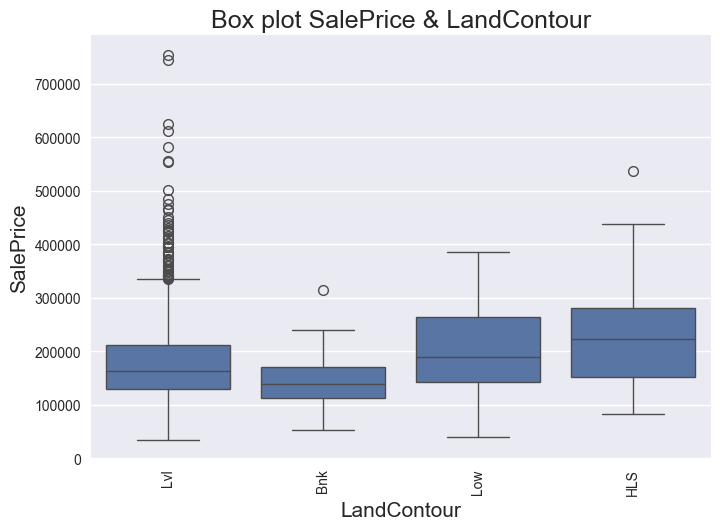

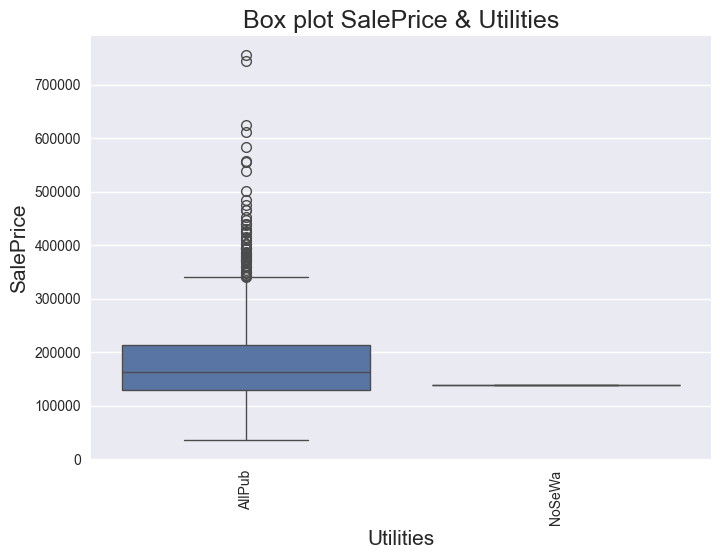

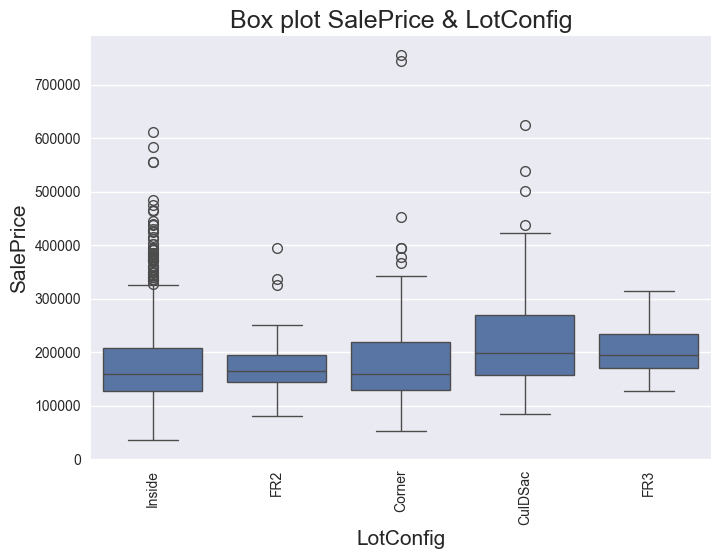

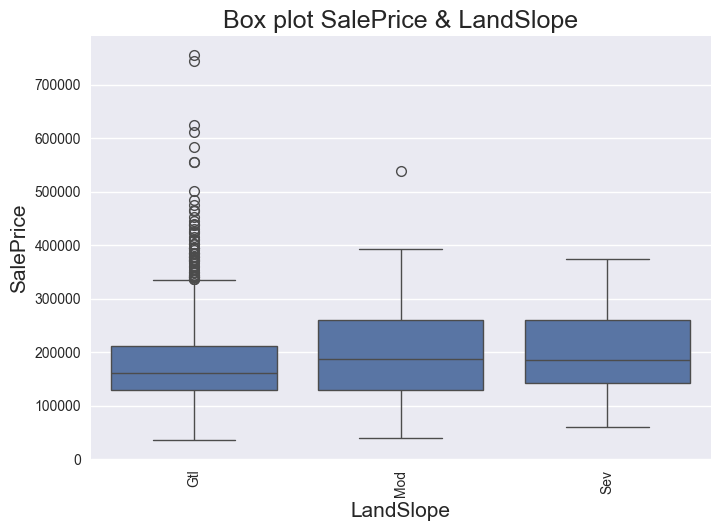

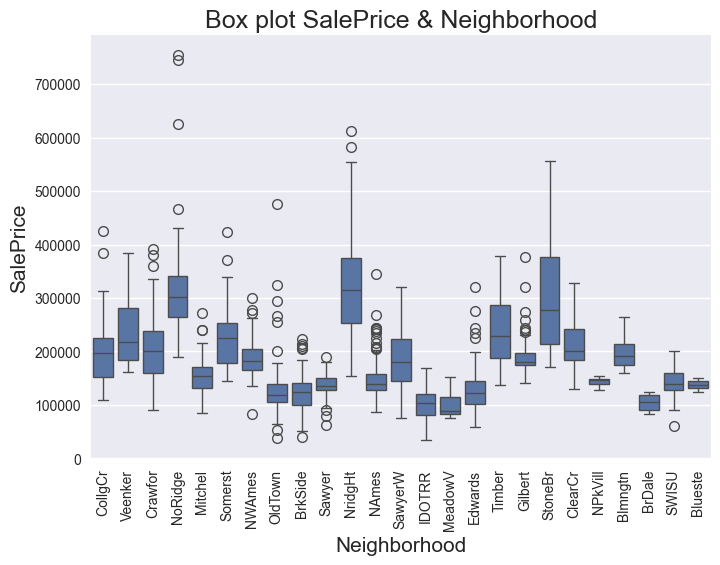

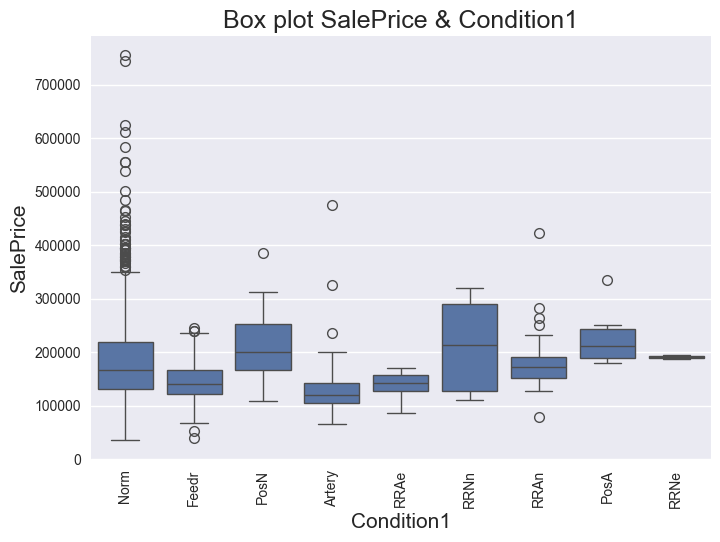

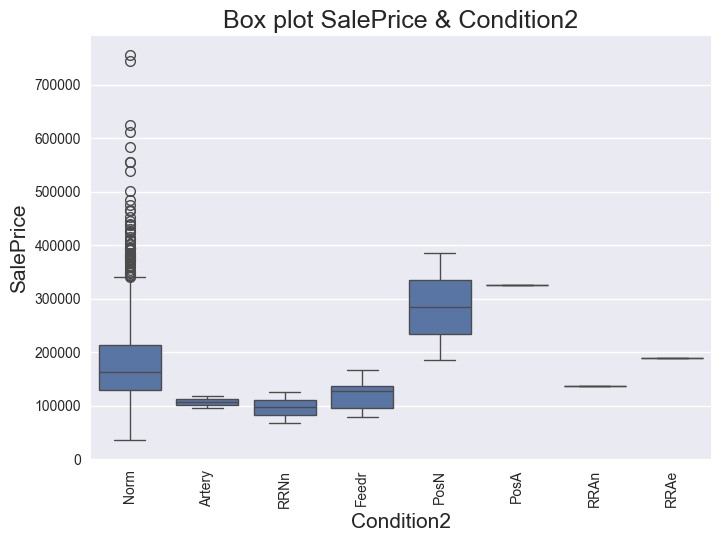

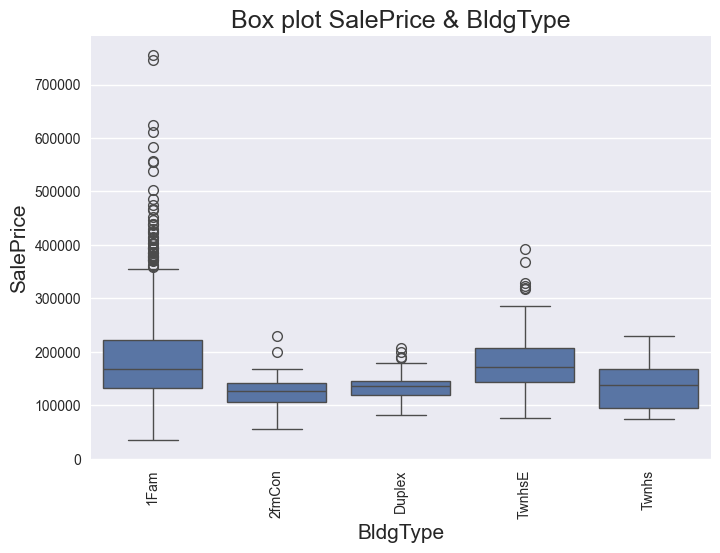

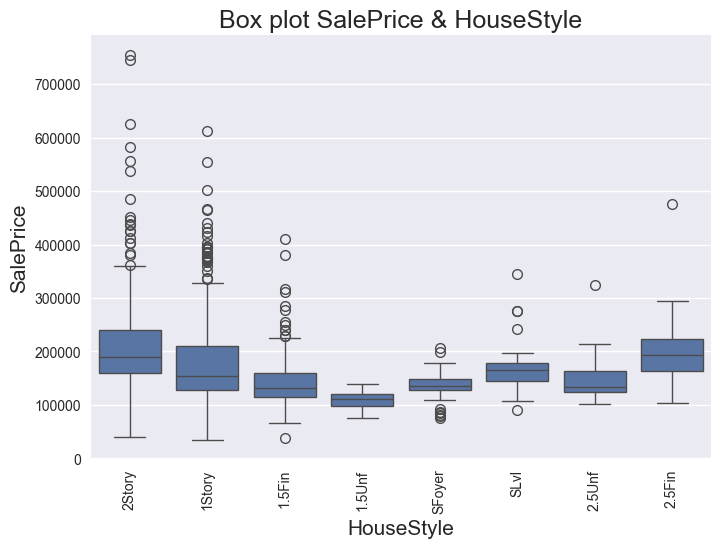

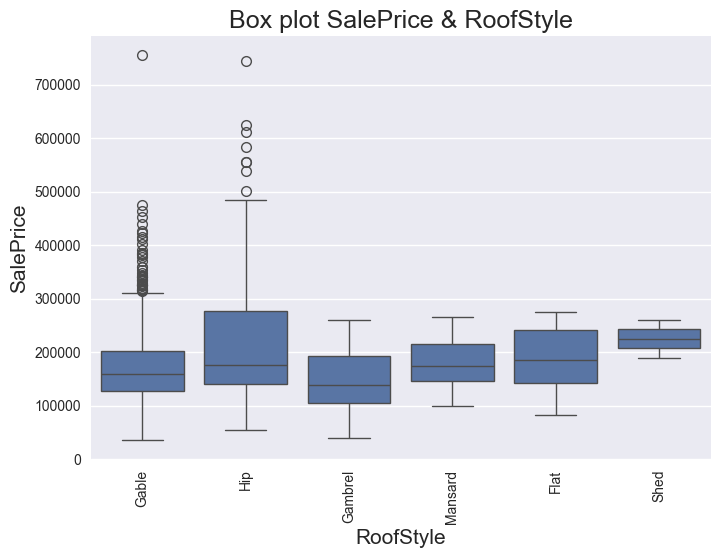

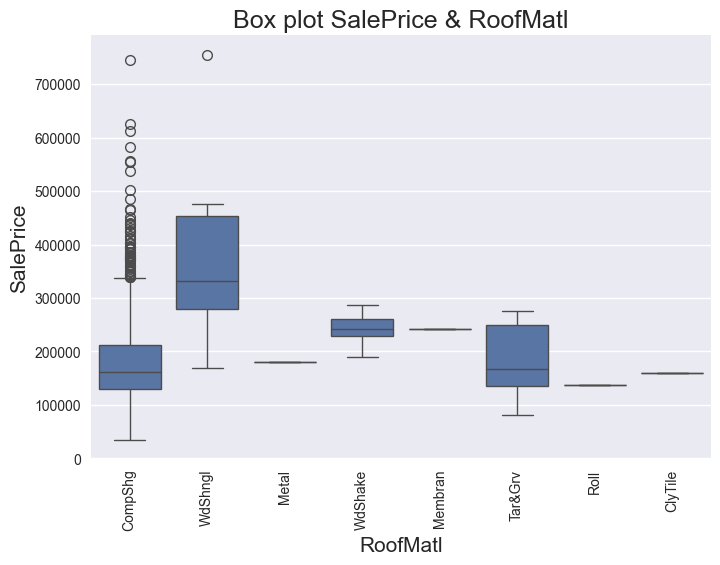

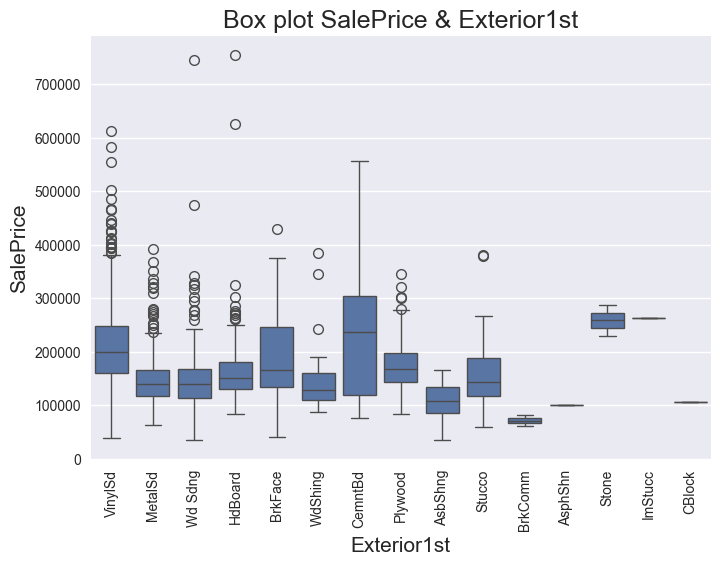

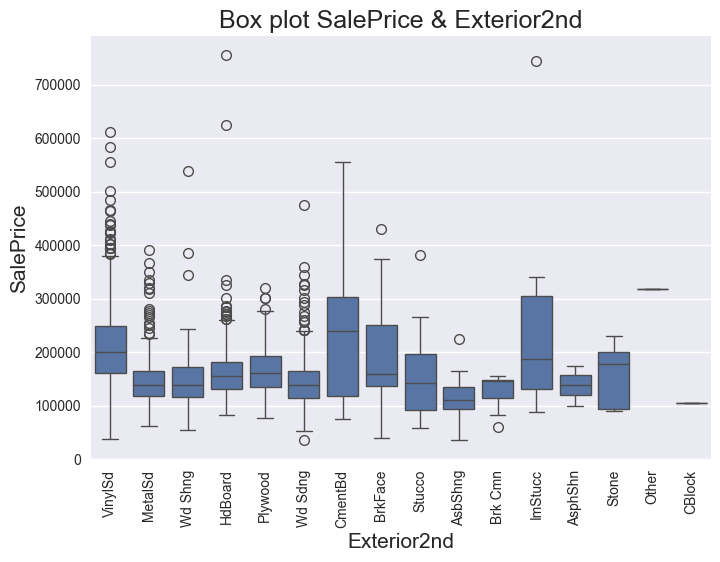

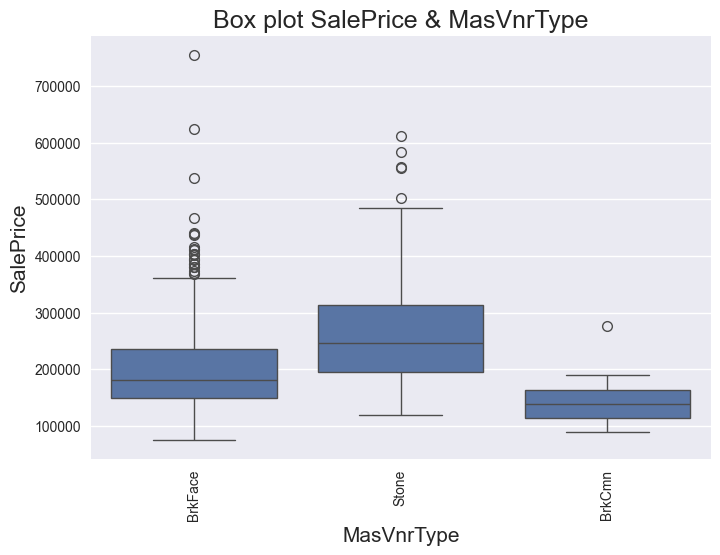

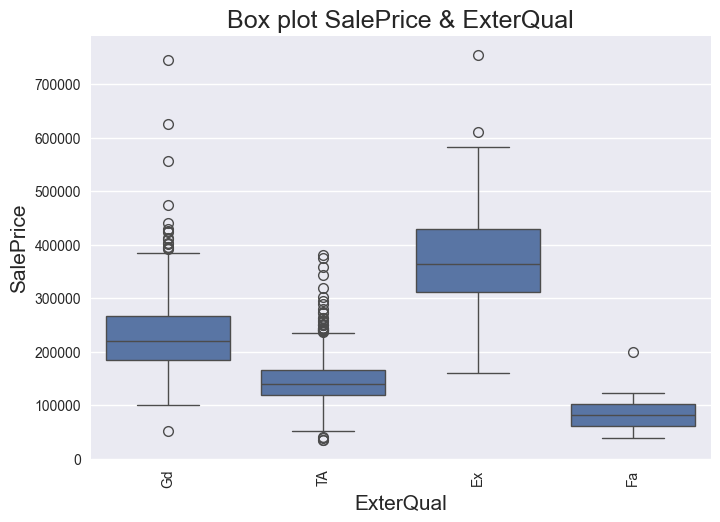

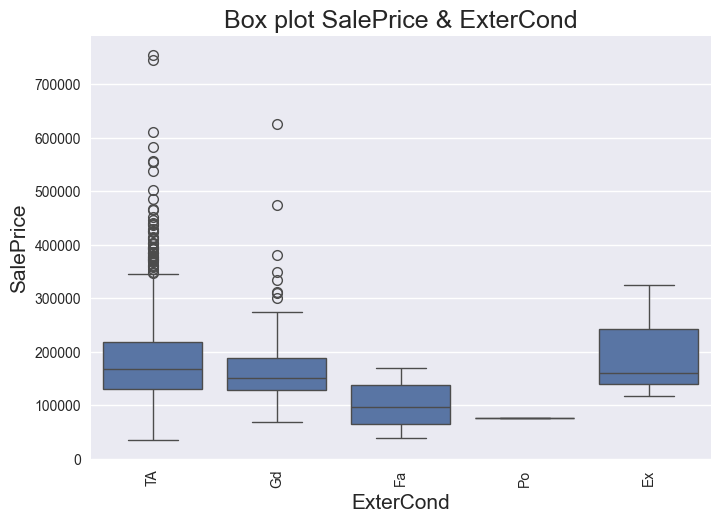

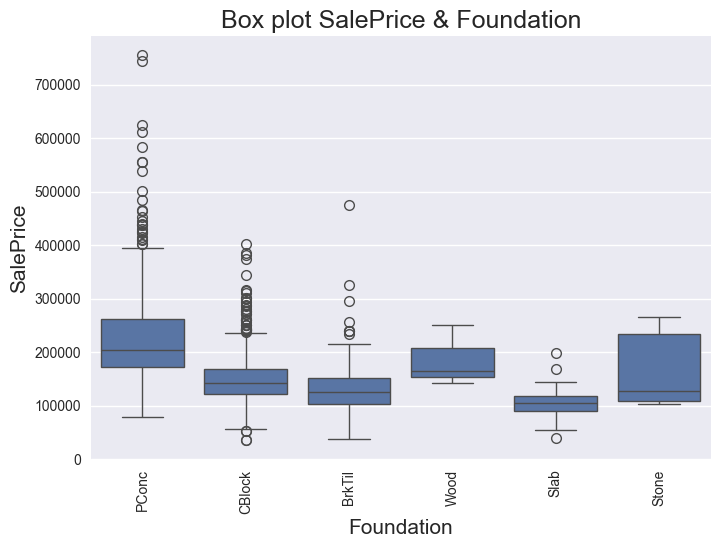

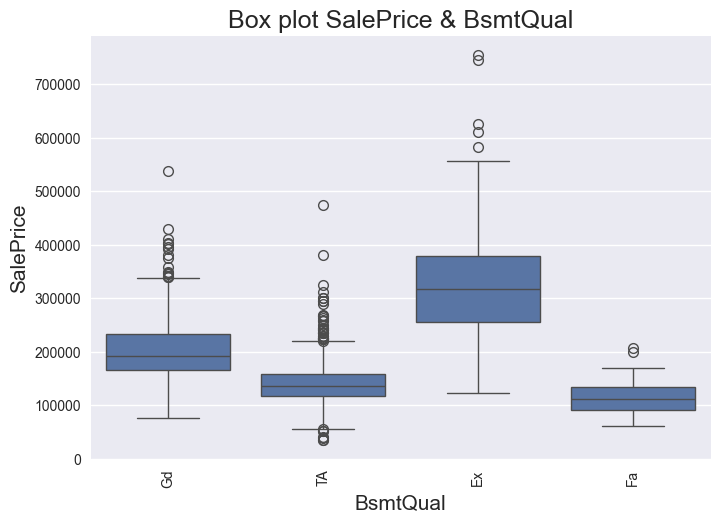

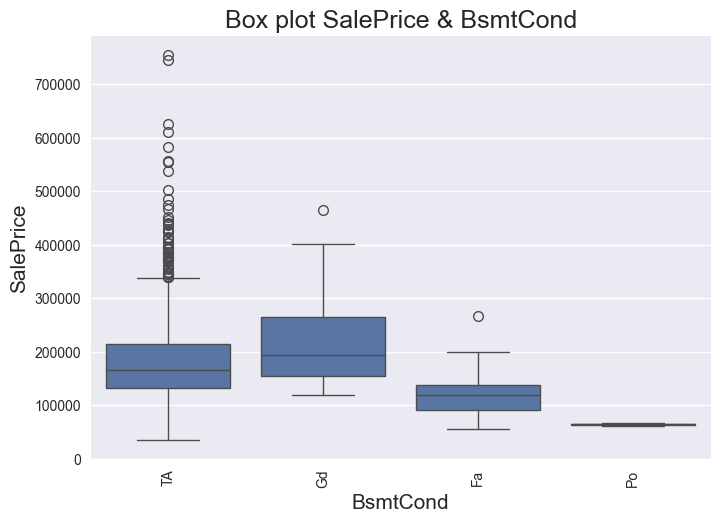

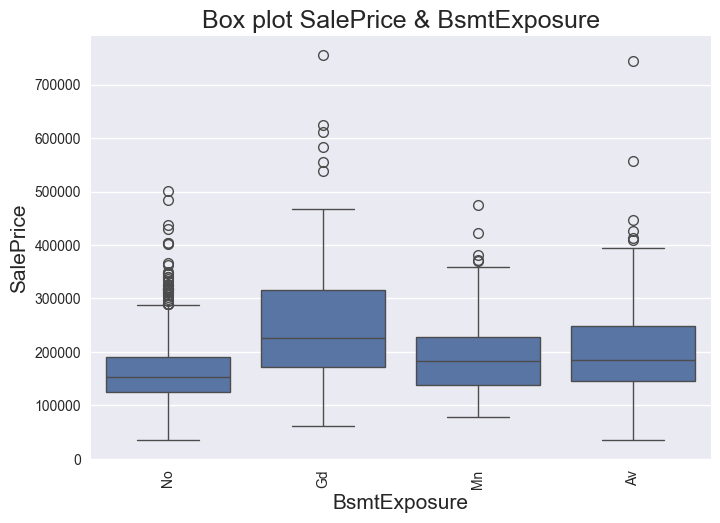

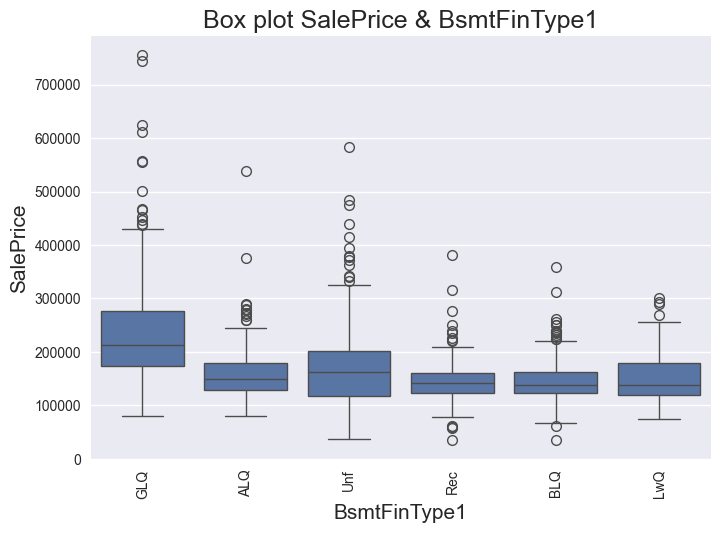

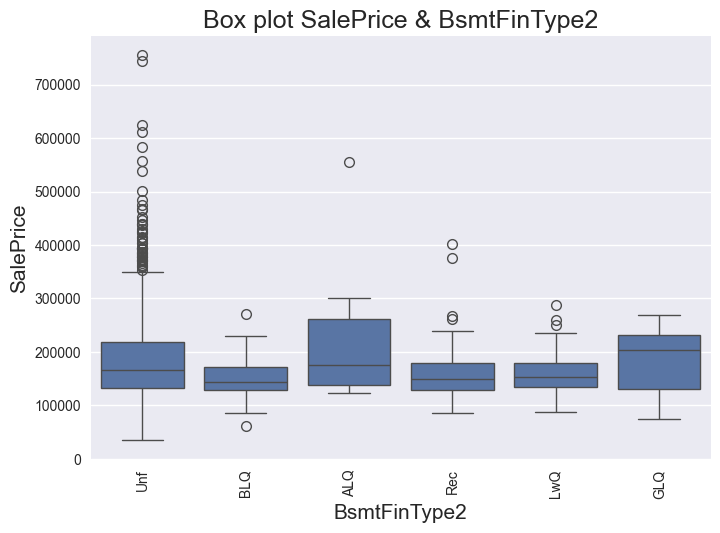

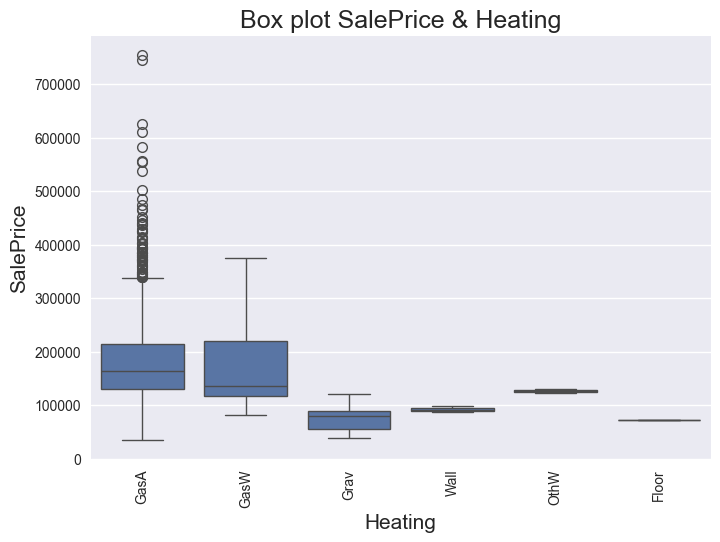

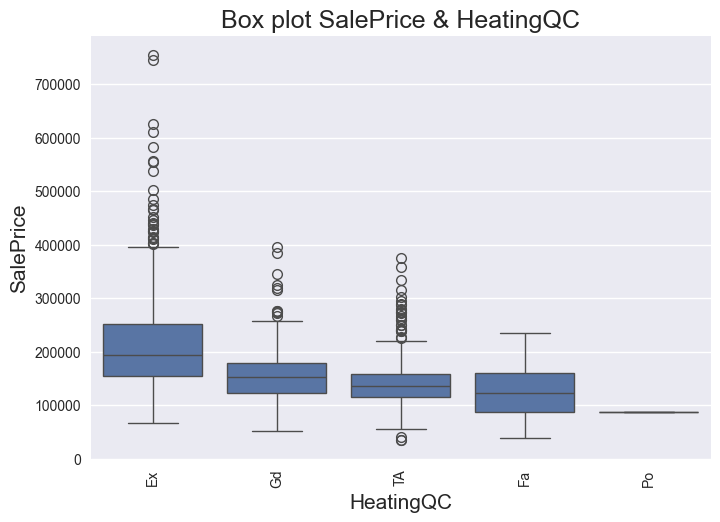

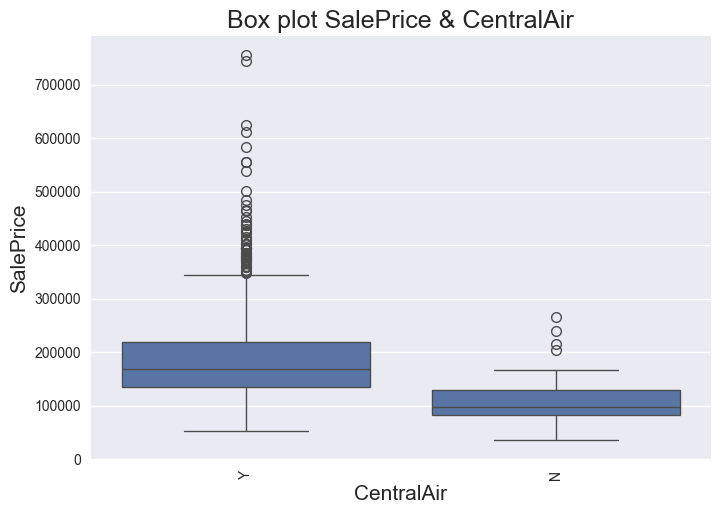

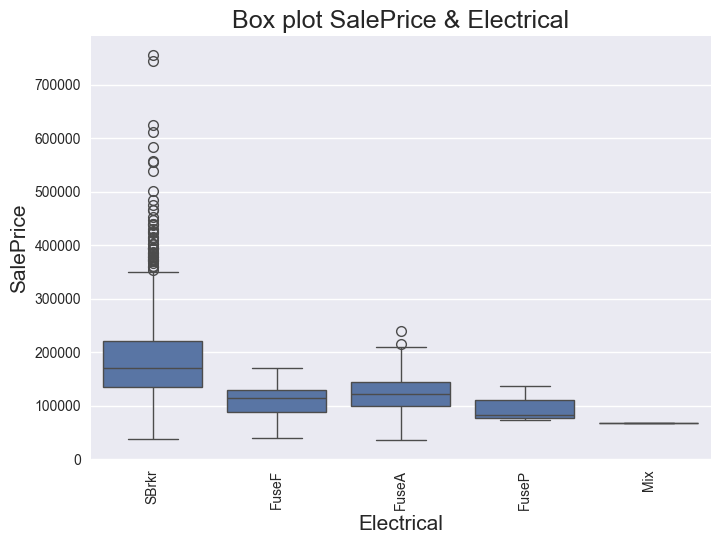

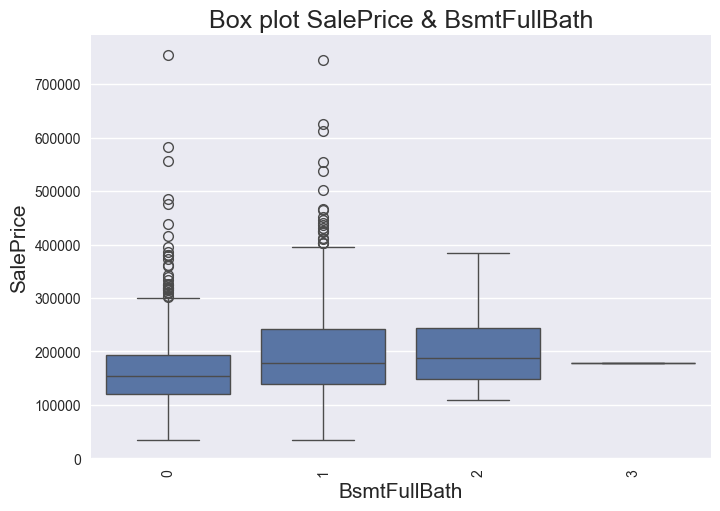

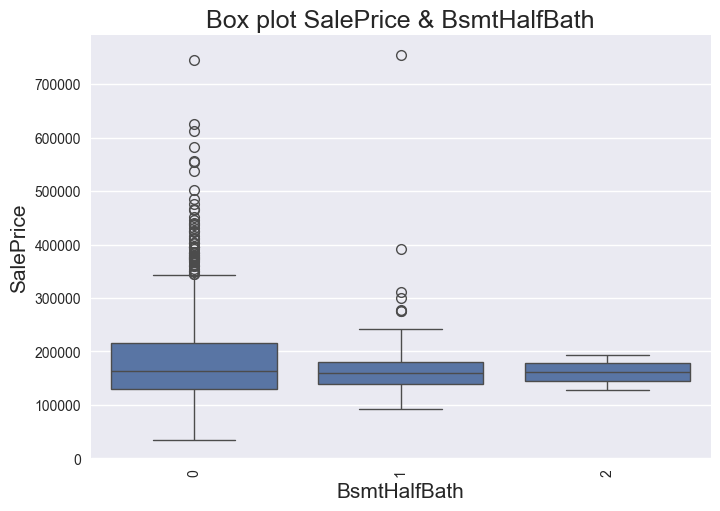

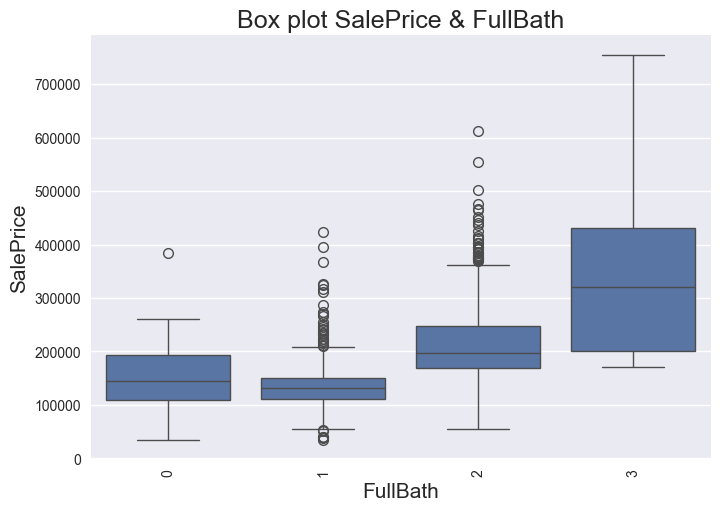

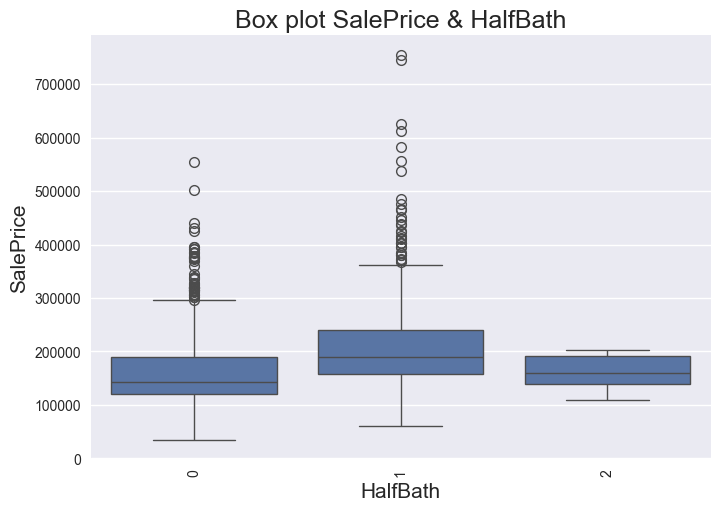

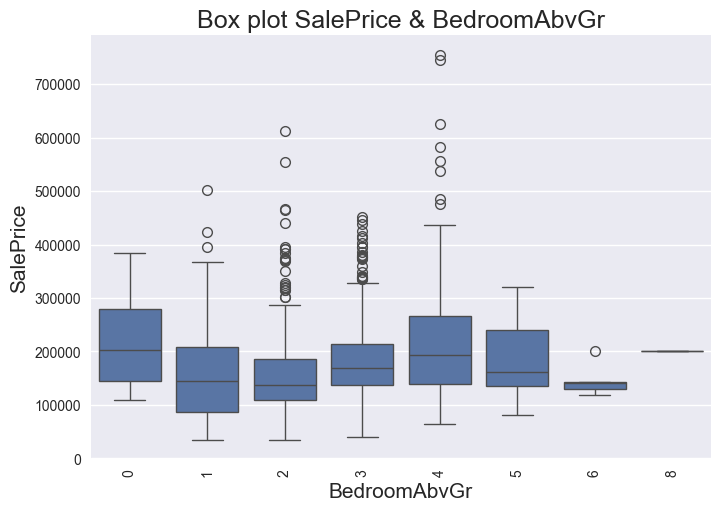

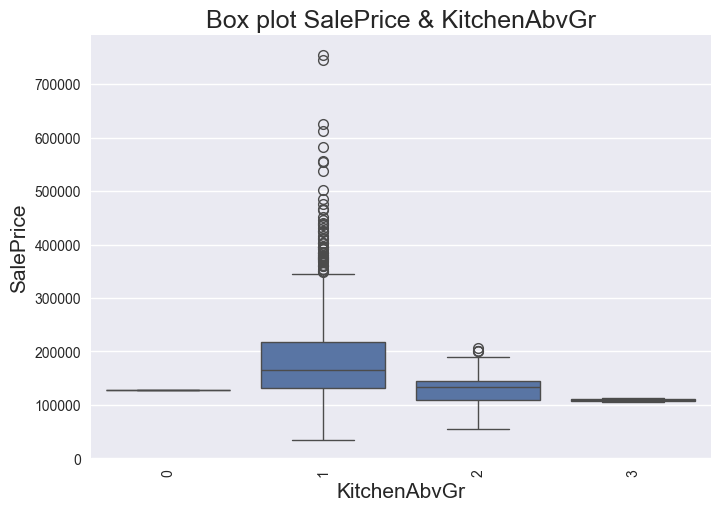

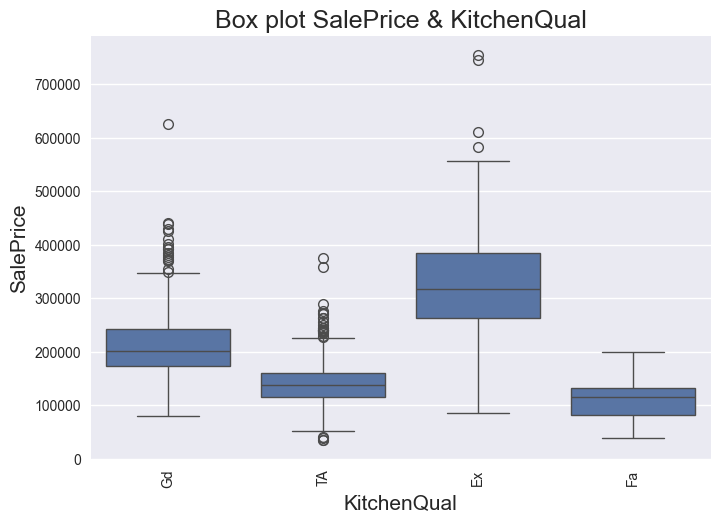

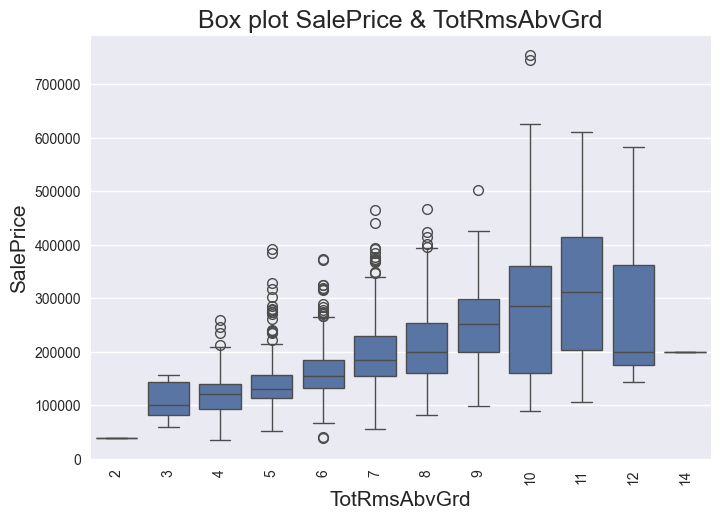

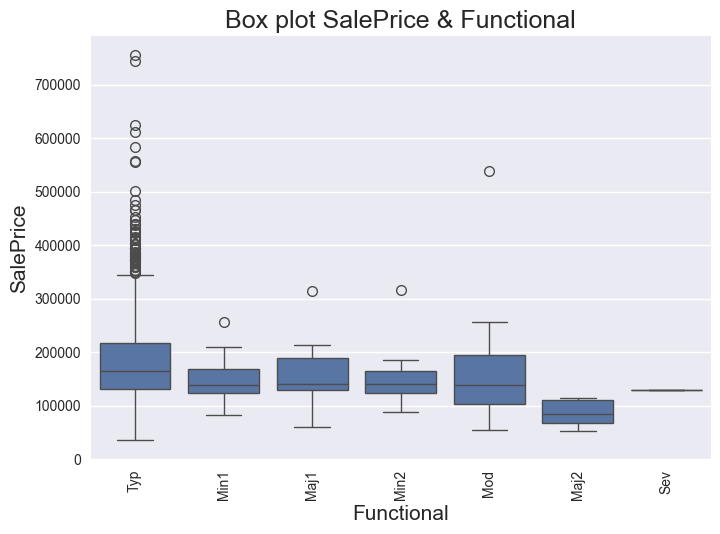

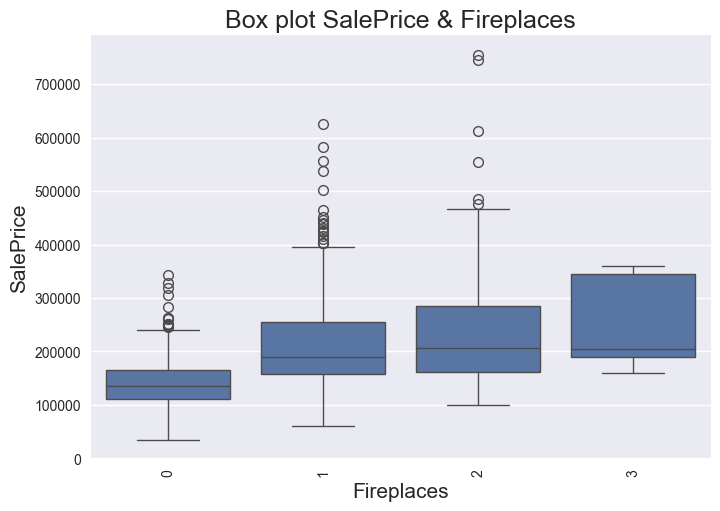

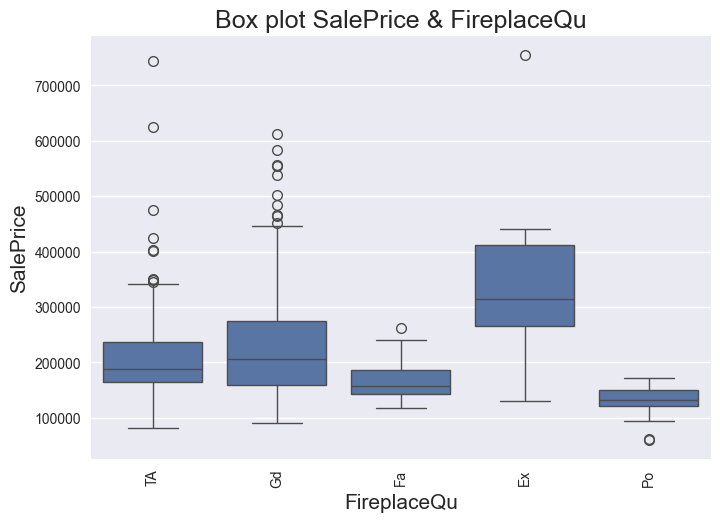

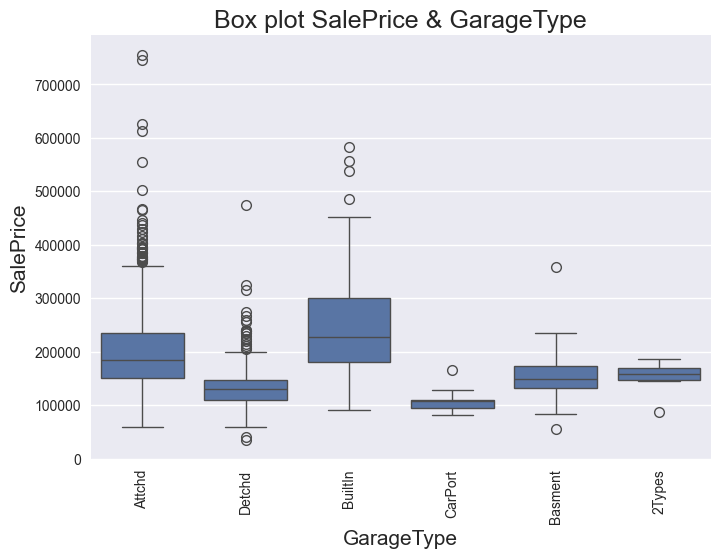

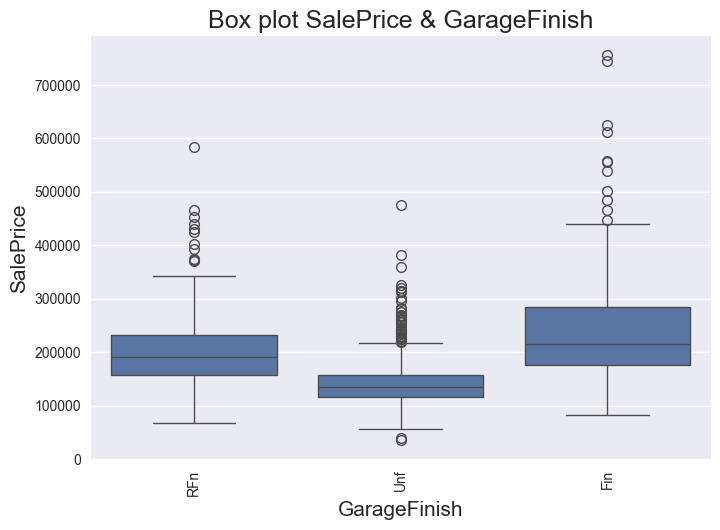

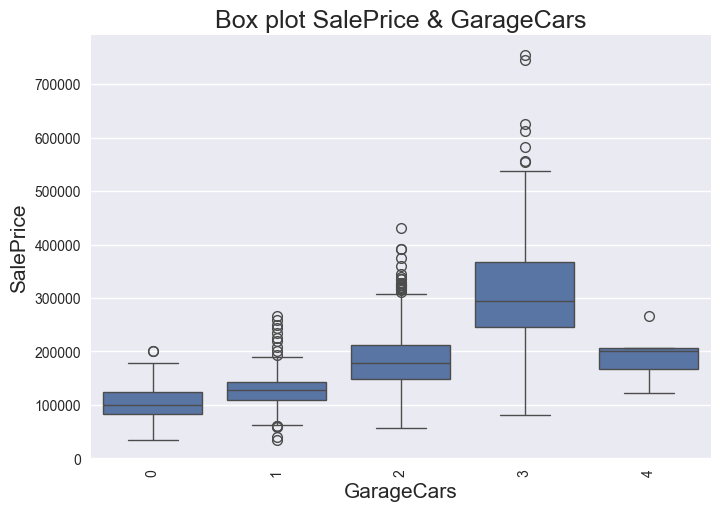

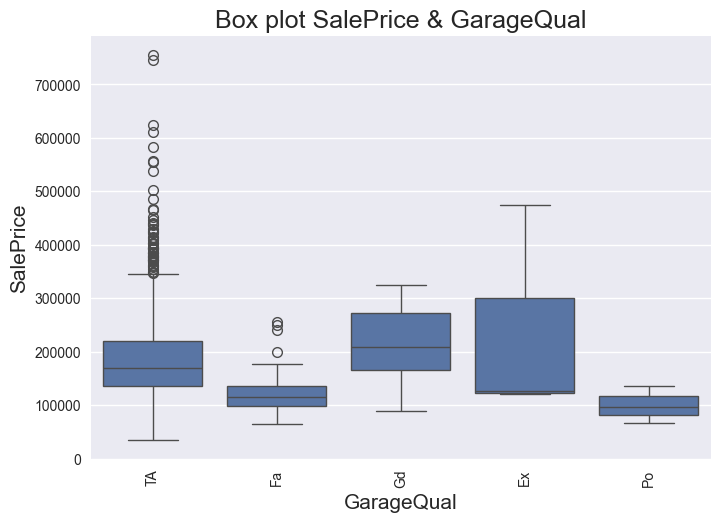

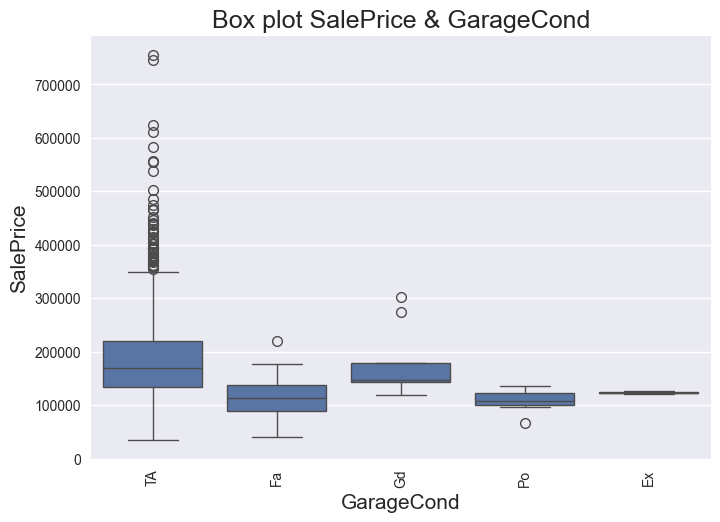

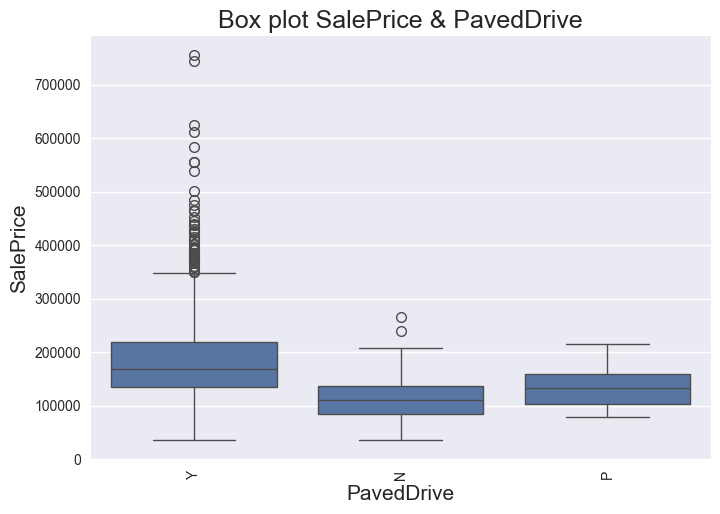

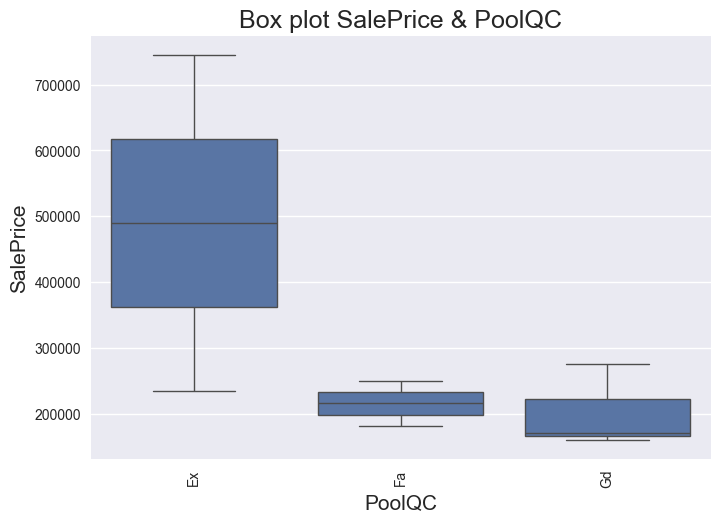

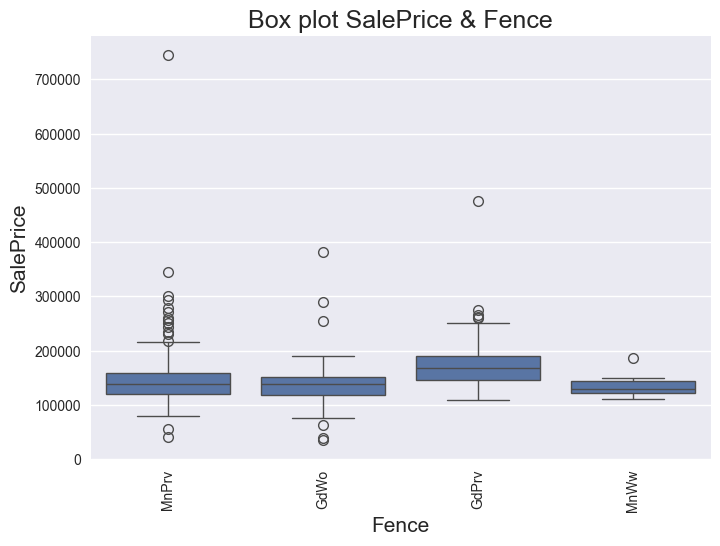

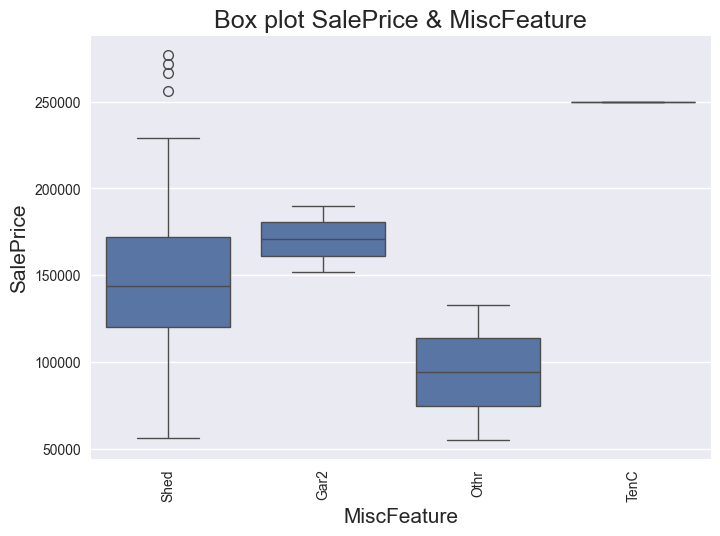

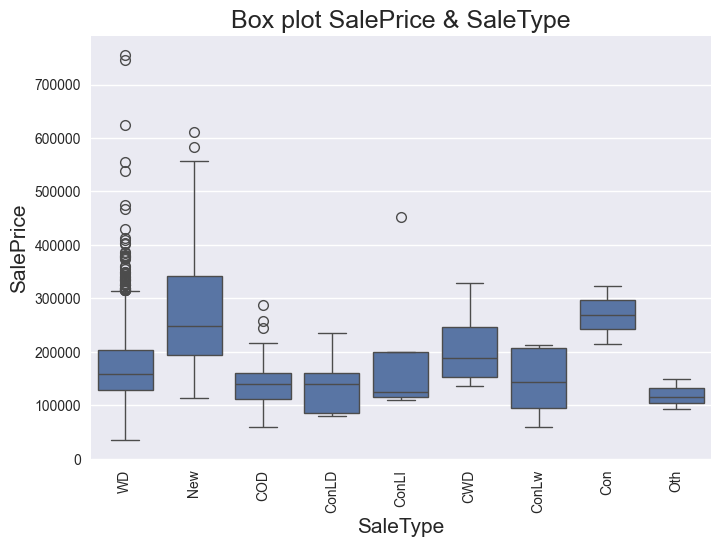

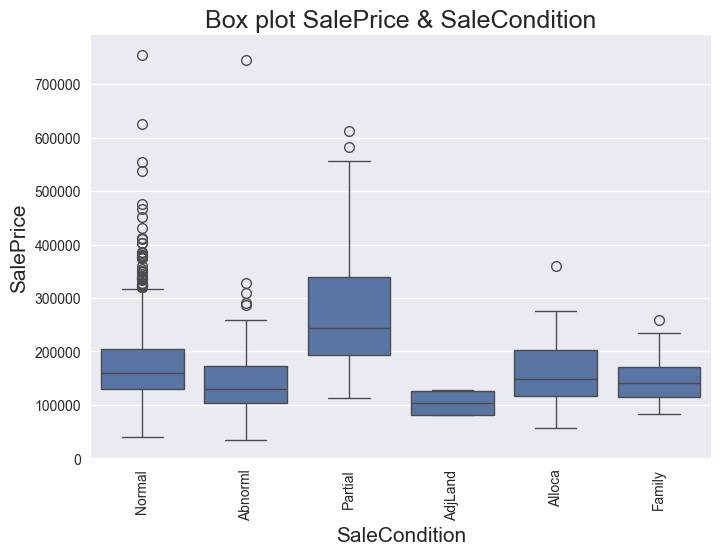

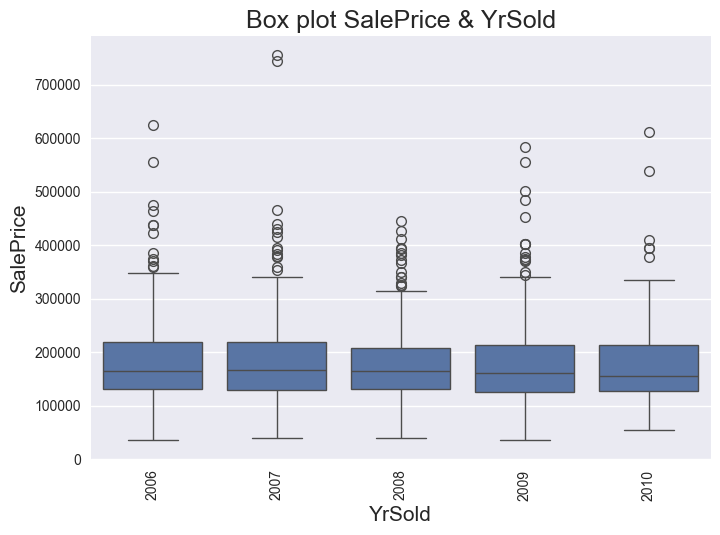

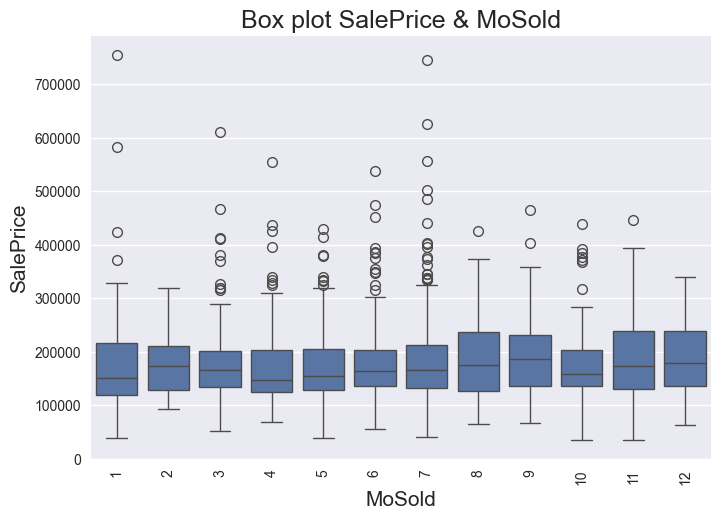

In [212]:
box_plots(train_clean['SalePrice'], train_raw, categorical)


## Model enginering

### Base pipeline


In [213]:
qualitative = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
              'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
              'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
              'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
              'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 
              'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
              'SaleType', 'SaleCondition', 'MoSold']

quantitative = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',  
               'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
               'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
               'PoolArea', 'MiscVal']

date = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt']

In [214]:
data_raw = pd.concat([train_raw, validation_raw])

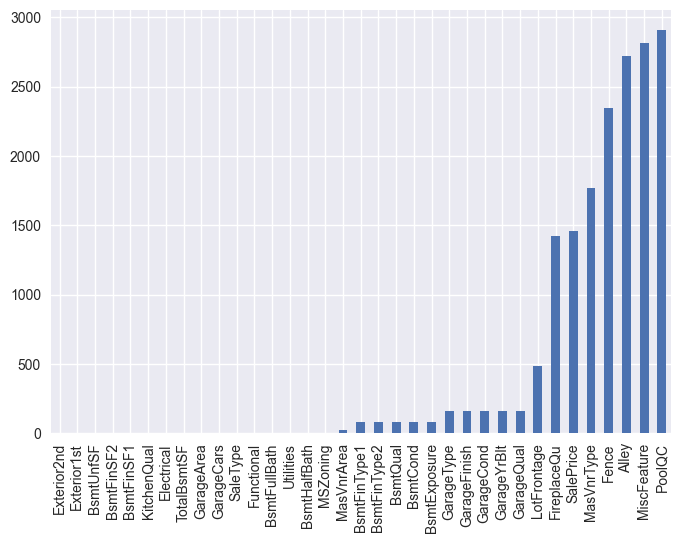

In [215]:
plot_missing(data_raw)

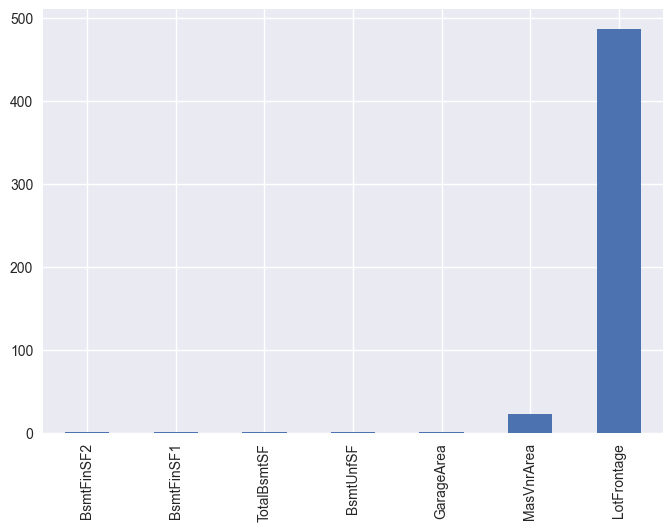

In [216]:
plot_missing(data_raw[quantitative])

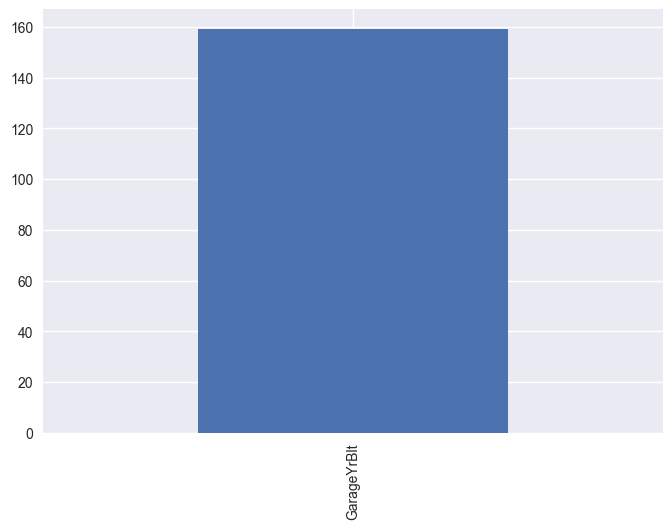

In [217]:
plot_missing(data_raw[date])

In [218]:
data_clean = clean(data_raw)

data_clean.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave    NA      Reg   
2           20       RL         80.0     9600   Pave    NA      Reg   
3           60       RL         68.0    11250   Pave    NA      IR1   
4           70       RL         60.0     9550   Pave    NA      IR1   
5           60       RL         84.0    14260   Pave    NA      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0     NA    NA          NA   
2          Lvl    AllPub       FR2  ...        0     NA    NA          NA   
3          Lvl    AllPub    Inside  ...        0     NA    NA          NA   
4          Lvl    AllPub    Corner  ...        0     NA    NA          NA   
5          Lvl    AllPub       FR2  ...        0     NA    NA          NA   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal   208500.0  
2        0      5    2007        WD         Normal   181500.0  
3        0      9    2008        WD         Normal   223500.0  
4        0      2    2006        WD        Abnorml   140000.0  
5        0     12    2008        WD         Normal   250000.0  

[5 rows x 80 columns]

In [219]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
               'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
               'KitchenQual','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 
               'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 
               'MiscFeature', 'SaleType', 'SaleCondition', 'YrSold', 'MoSold']

numeric = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
           'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
           'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt']

# Split of the clean dataset into train & validation
train_clean = data_clean[data_clean.index.isin(train_raw.index)]
validation_clean = data_clean[data_clean.index.isin(validation_raw.index)]

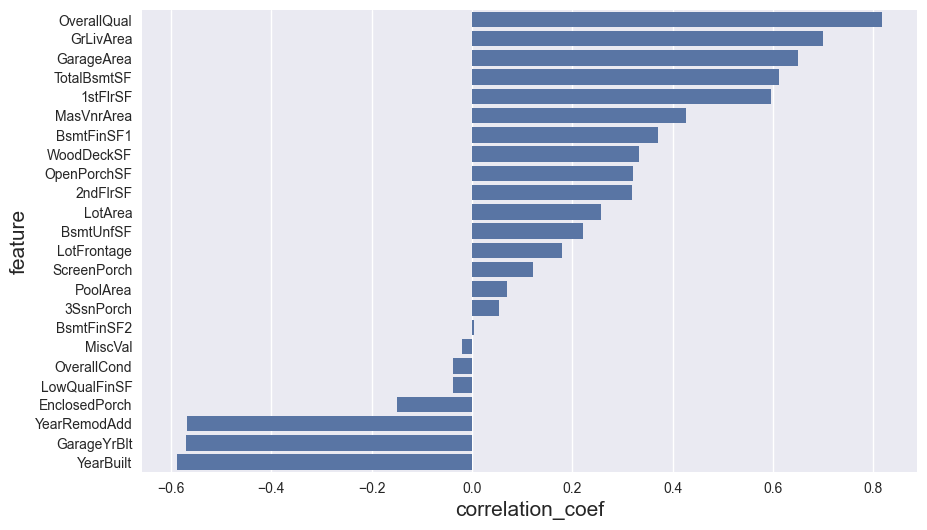

In [220]:
cor = correlation(target, train_clean, numeric, method = 'pearson')

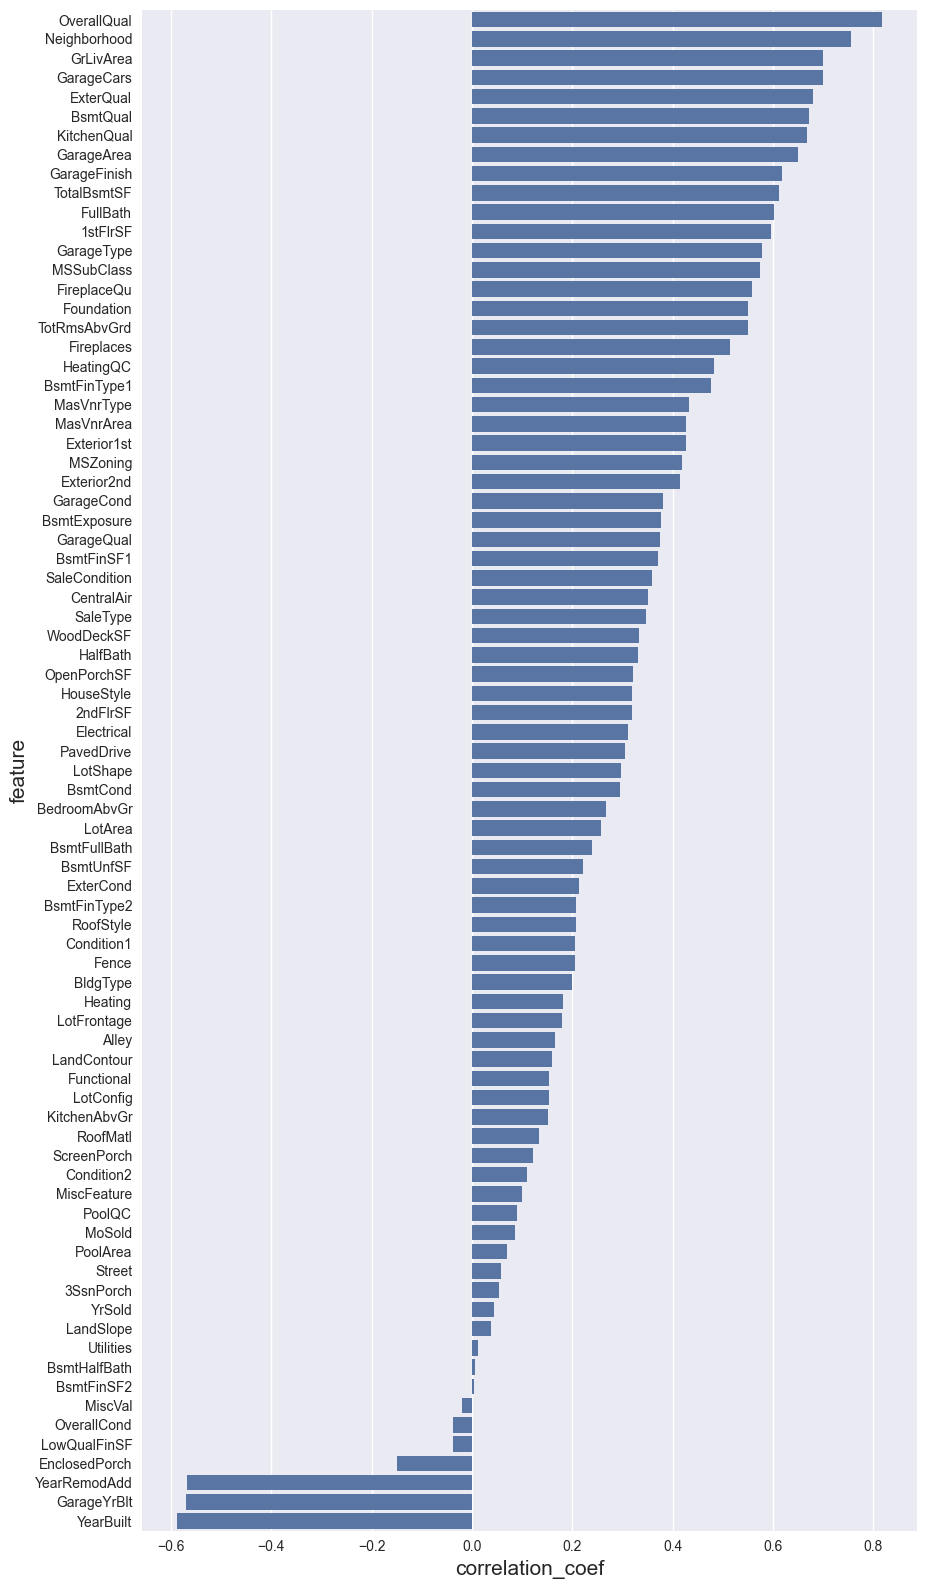

In [221]:
data_preprocess = encode_with_mean(data_clean, target, categorical)

# Split of the clean dataset into train & validation
train_preprocess = data_preprocess[data_preprocess.index.isin(train_raw.index)]
validation_preprocess = data_preprocess[data_preprocess.index.isin(validation_raw.index)]

cor = correlation(target, train_preprocess, numeric + categorical)

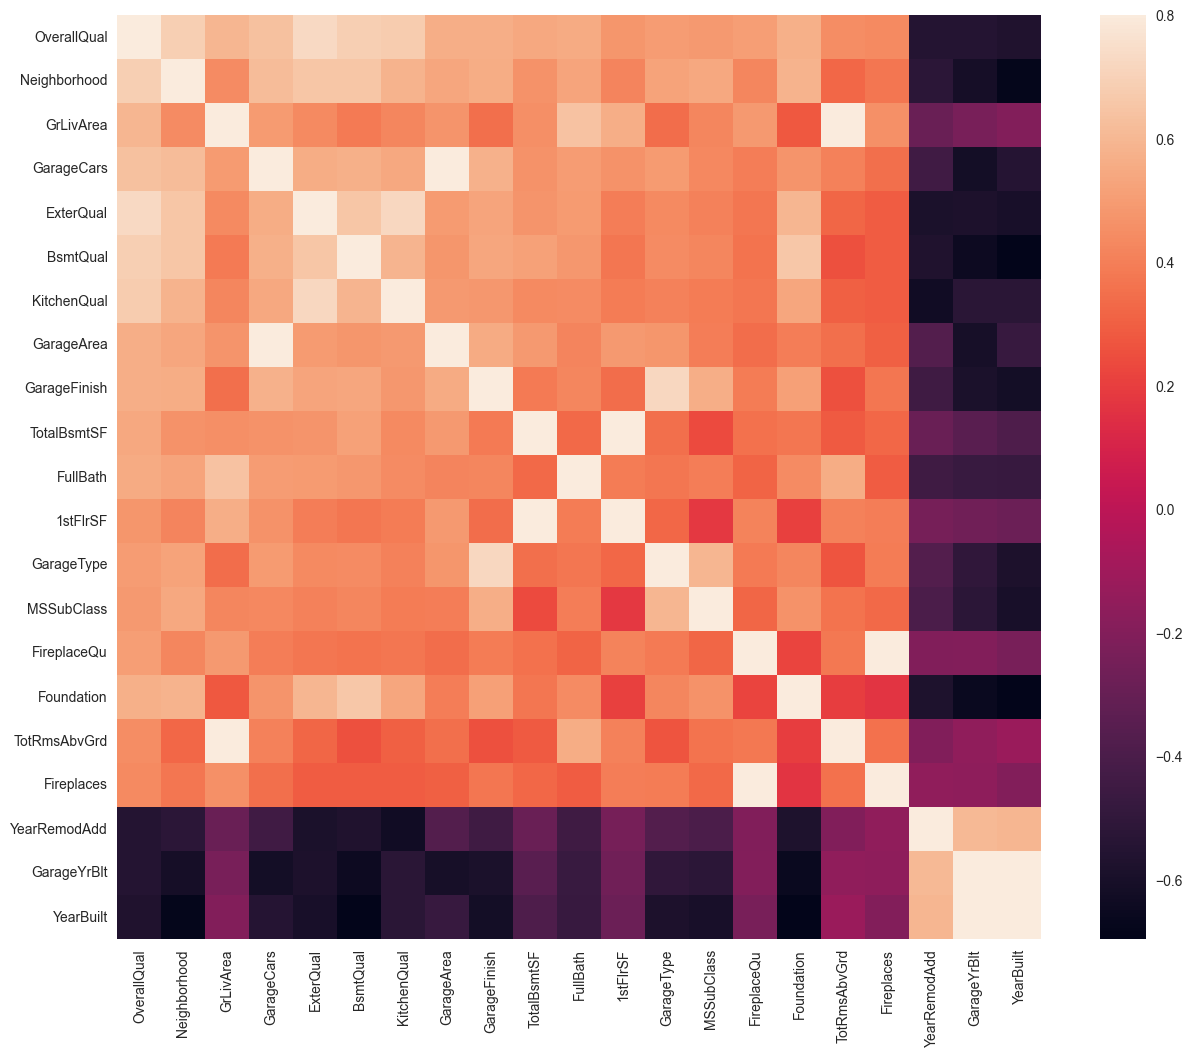

In [222]:
cols = cor[abs(cor['correlation_coef']) > 0.5]['feature'].tolist()
correlation_matrix = train_preprocess[cols].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(correlation_matrix, vmax=.8, square=True)
plt.show()

Using only this 5 columns

In [223]:
base = ['OverallQual', 'Neighborhood', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [224]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1367.
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:11:21   Log-Likelihood:                 539.40
No. Observations:                1460   AIC:                            -1067.
Df Residuals:                    1454   BIC:                            -1035.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            6.8392      0.271     25.244   

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


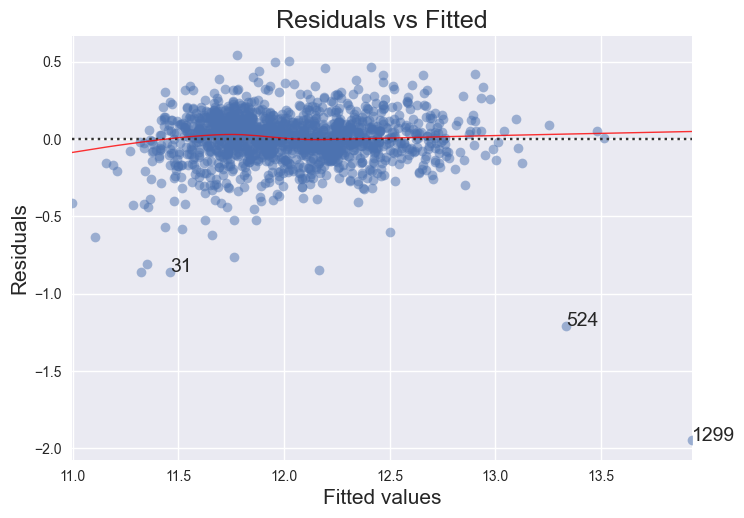

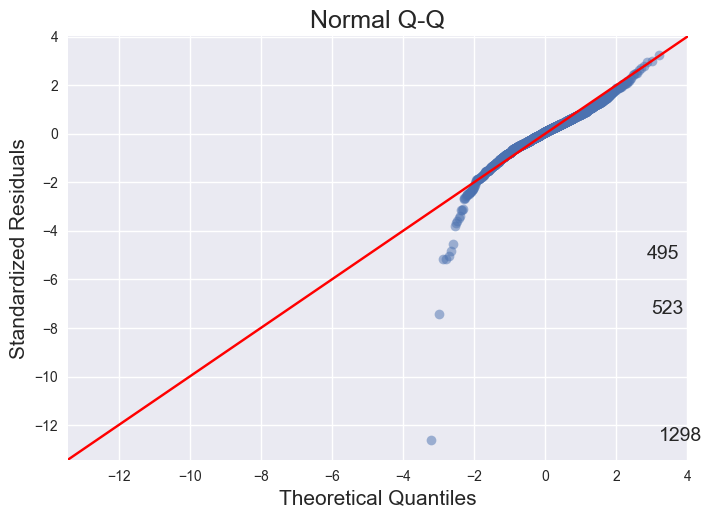

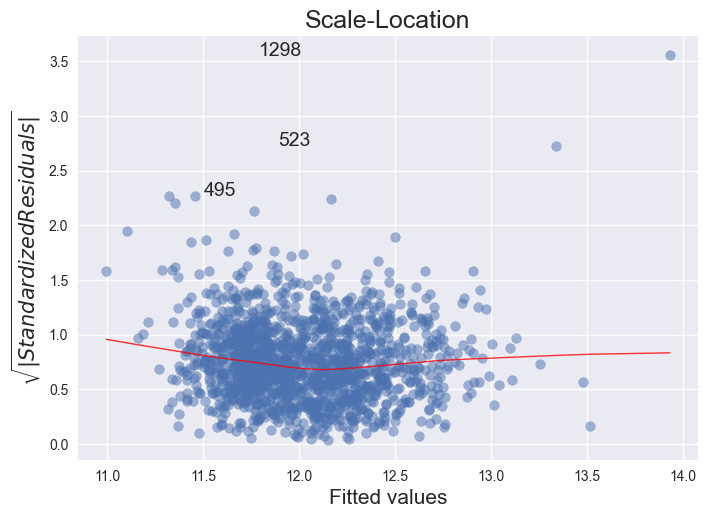

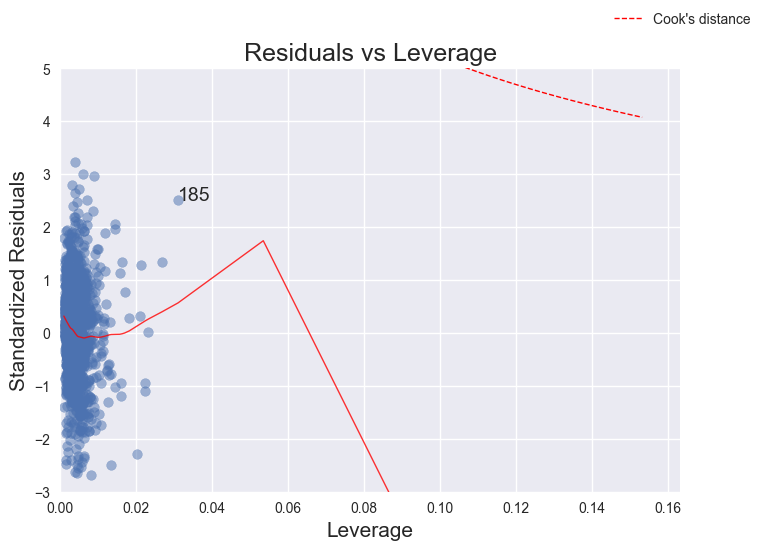

In [225]:
diagnostic_plots(sm.add_constant(X), y)

In [226]:
print(X[base].iloc[[523, 1298]])

      OverallQual  Neighborhood  GrLivArea  TotalBsmtSF  YearBuilt
Id                                                                
524            10     11.712321       4676       3138.0          0
1299           10     11.712321       5642       6110.0          0


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     1522.
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:11:22   Log-Likelihood:                 659.93
No. Observations:                1429   AIC:                            -1308.
Df Residuals:                    1423   BIC:                            -1276.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.7556      0.257     30.195   

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


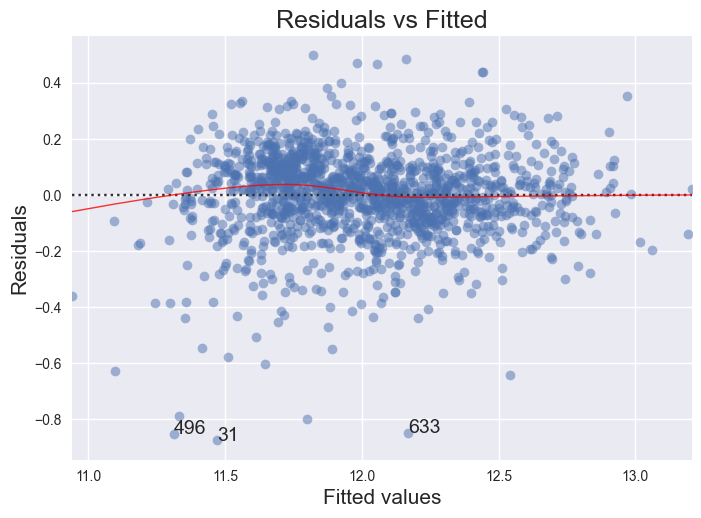

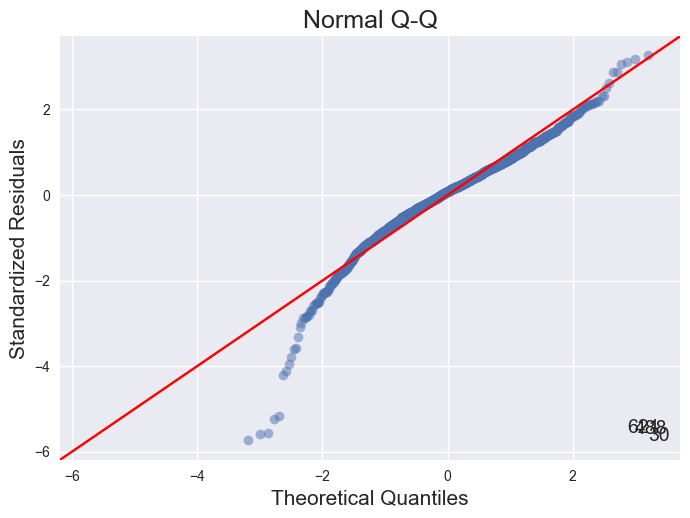

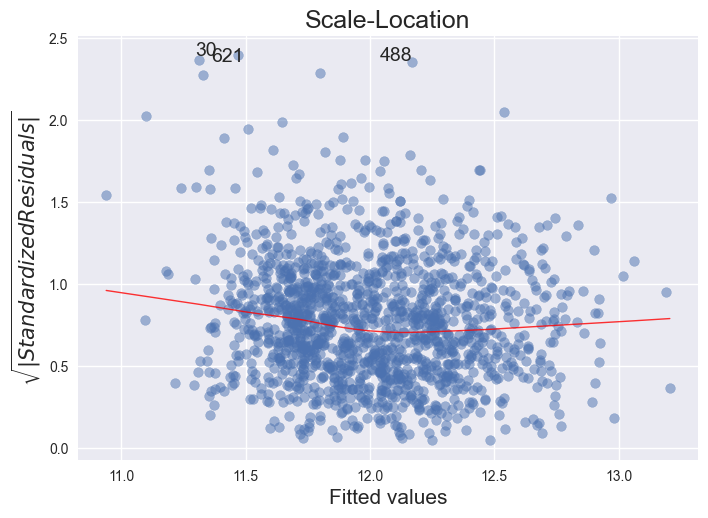

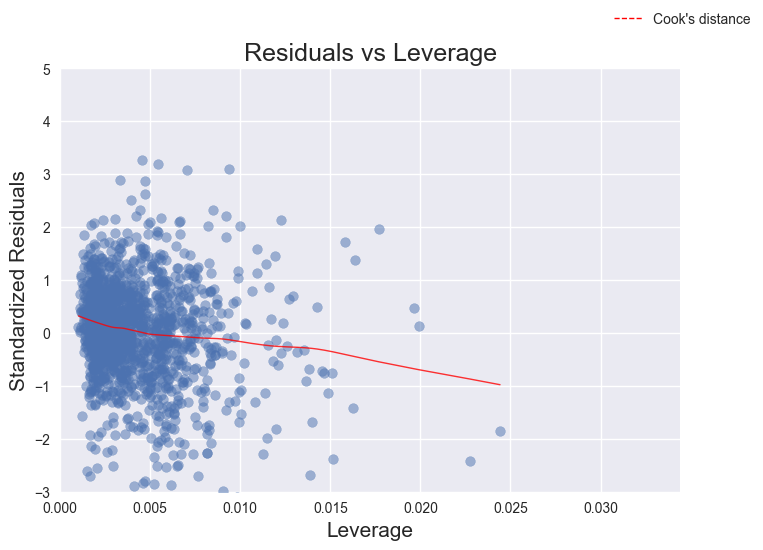

In [227]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

In [228]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.214534
2    12.081588
3    12.244451
4    12.046219
5    12.620316
dtype: float64


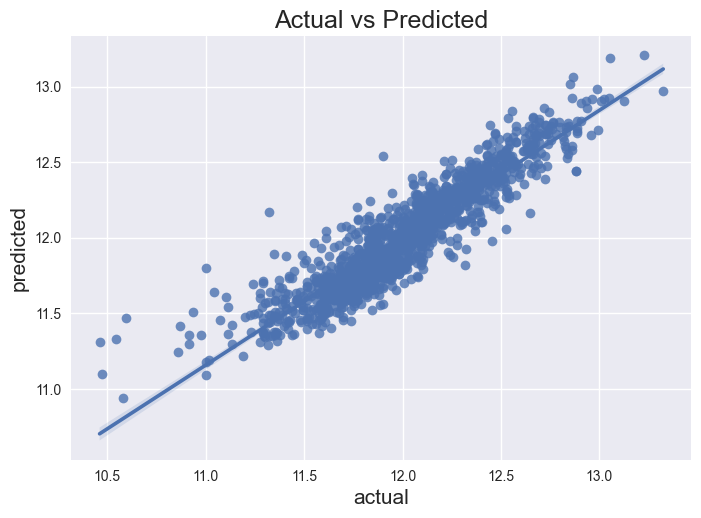

In [229]:
plot_prediction(y, y_pred)

In [230]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.1524750806291098


In [231]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.663271
1462    11.946171
1463    12.025787
1464    12.101195
1465    12.341289
dtype: float64


In [232]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('baseline.csv', index = False)

### Model 1
Utilisation de quelques colonnes supplémentaires

Colonnes retenues :
- OverallQual : Qualité générale
- OverallCond : Condition générale
- Neighborhood : Quartier
- GrLivArea : Superficie de l'habitation
- LotArea : Superficie du terrain
- YearBuilt : Année de construction
- Foundation : Type de fondation
- TotRmsAbvGrd : Nombre de chambres, salles de bain exclues
- GarageArea : Taille du garage
- PoolArea : Taille de la piscine, 0 si pas à vérifier la pertinence


In [245]:
base = ['OverallQual', 'OverallCond', 'Neighborhood', 'GrLivArea', 'LotArea', 'YearBuilt', 'Foundation','TotRmsAbvGrd',
        'GarageArea', 'PoolArea']

X = train_preprocess[base]
X_val = validation_preprocess[base]

y = target.copy()

In [234]:
lasso_alphas = 10**np.linspace(-6,0,100)
lasso_alphas

array([1.00000000e-06, 1.14975700e-06, 1.32194115e-06, 1.51991108e-06,
       1.74752840e-06, 2.00923300e-06, 2.31012970e-06, 2.65608778e-06,
       3.05385551e-06, 3.51119173e-06, 4.03701726e-06, 4.64158883e-06,
       5.33669923e-06, 6.13590727e-06, 7.05480231e-06, 8.11130831e-06,
       9.32603347e-06, 1.07226722e-05, 1.23284674e-05, 1.41747416e-05,
       1.62975083e-05, 1.87381742e-05, 2.15443469e-05, 2.47707636e-05,
       2.84803587e-05, 3.27454916e-05, 3.76493581e-05, 4.32876128e-05,
       4.97702356e-05, 5.72236766e-05, 6.57933225e-05, 7.56463328e-05,
       8.69749003e-05, 1.00000000e-04, 1.14975700e-04, 1.32194115e-04,
       1.51991108e-04, 1.74752840e-04, 2.00923300e-04, 2.31012970e-04,
       2.65608778e-04, 3.05385551e-04, 3.51119173e-04, 4.03701726e-04,
       4.64158883e-04, 5.33669923e-04, 6.13590727e-04, 7.05480231e-04,
       8.11130831e-04, 9.32603347e-04, 1.07226722e-03, 1.23284674e-03,
       1.41747416e-03, 1.62975083e-03, 1.87381742e-03, 2.15443469e-03,
      

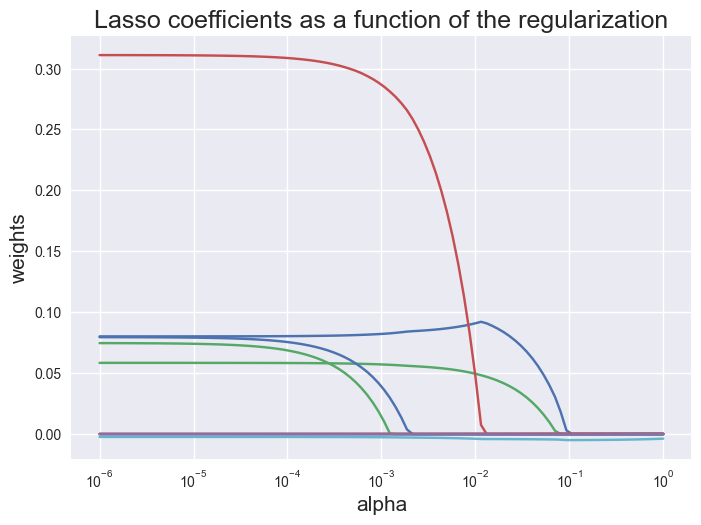

In [246]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

lasso_regression = Lasso(max_iter=10000)
lasso_coefs = []
lasso_cv = []

for alpha in lasso_alphas:
    lasso_regression.set_params(alpha=alpha)
    lasso_regression.fit(X, y)
    lasso_coefs.append(lasso_regression.coef_)
    lasso_cv.append(cross_val_score(lasso_regression, X, y, cv=5, scoring='r2', n_jobs=-1).mean())

# Plot coefs against the alphas
ax = plt.gca()
ax.plot(lasso_alphas, lasso_coefs)

# Adding titles and labels
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')

# Show the plot
plt.show()

In [241]:
ridge_alphas = 10**np.linspace(-3,5,100)
ridge_alphas

array([1.00000000e-03, 1.20450354e-03, 1.45082878e-03, 1.74752840e-03,
       2.10490414e-03, 2.53536449e-03, 3.05385551e-03, 3.67837977e-03,
       4.43062146e-03, 5.33669923e-03, 6.42807312e-03, 7.74263683e-03,
       9.32603347e-03, 1.12332403e-02, 1.35304777e-02, 1.62975083e-02,
       1.96304065e-02, 2.36448941e-02, 2.84803587e-02, 3.43046929e-02,
       4.13201240e-02, 4.97702356e-02, 5.99484250e-02, 7.22080902e-02,
       8.69749003e-02, 1.04761575e-01, 1.26185688e-01, 1.51991108e-01,
       1.83073828e-01, 2.20513074e-01, 2.65608778e-01, 3.19926714e-01,
       3.85352859e-01, 4.64158883e-01, 5.59081018e-01, 6.73415066e-01,
       8.11130831e-01, 9.77009957e-01, 1.17681195e+00, 1.41747416e+00,
       1.70735265e+00, 2.05651231e+00, 2.47707636e+00, 2.98364724e+00,
       3.59381366e+00, 4.32876128e+00, 5.21400829e+00, 6.28029144e+00,
       7.56463328e+00, 9.11162756e+00, 1.09749877e+01, 1.32194115e+01,
       1.59228279e+01, 1.91791026e+01, 2.31012970e+01, 2.78255940e+01,
      

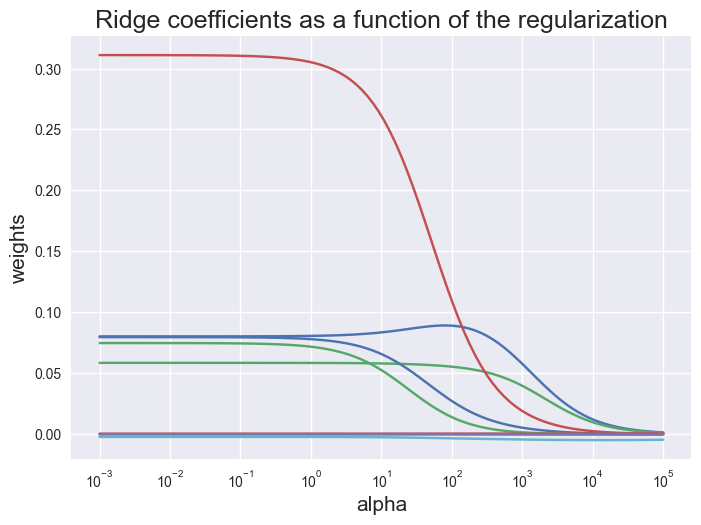

In [247]:
from sklearn.linear_model import Ridge

ridge_regression = Ridge()
ridge_coefs = []
ridge_cv = []

for alpha in ridge_alphas:
    ridge_regression.set_params(alpha=alpha)
    ridge_regression.fit(X, y)
    ridge_coefs.append(ridge_regression.coef_)
    ridge_cv.append(cross_val_score(ridge_regression, X, y, cv=5, scoring='r2', n_jobs=-1).mean())

# Plot coefs against the alphas
ax = plt.gca()
ax.plot(ridge_alphas, ridge_coefs)

# Adding titles and labels
plt.xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')

# Show the plot
plt.show()

In [248]:
import statsmodels.api as sm

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     839.8
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:51:55   Log-Likelihood:                 667.53
No. Observations:                1460   AIC:                            -1313.
Df Residuals:                    1449   BIC:                            -1255.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.2170      0.533      9.787   

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


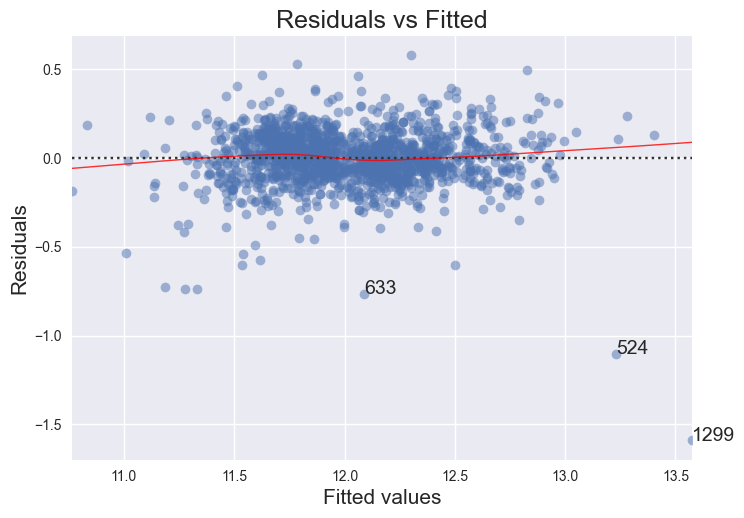

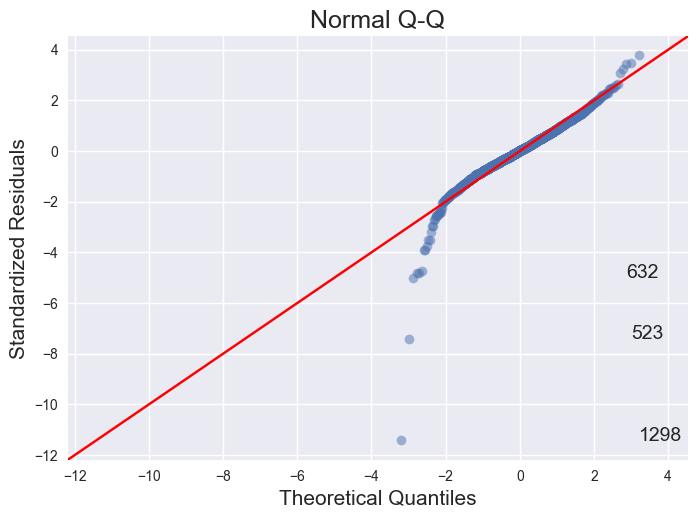

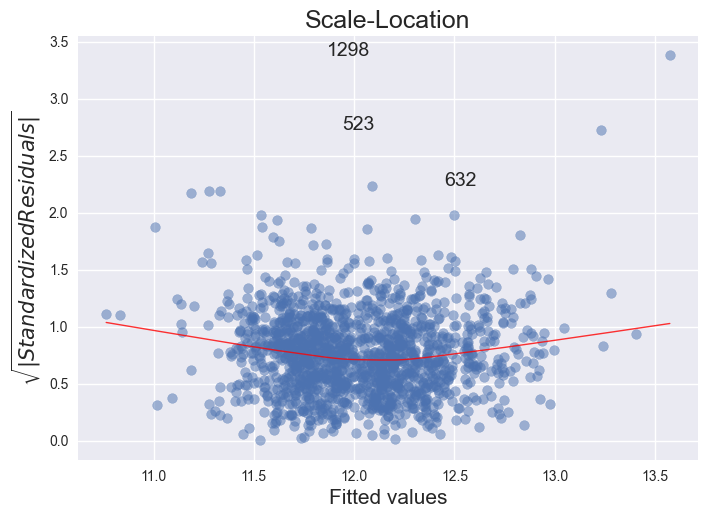

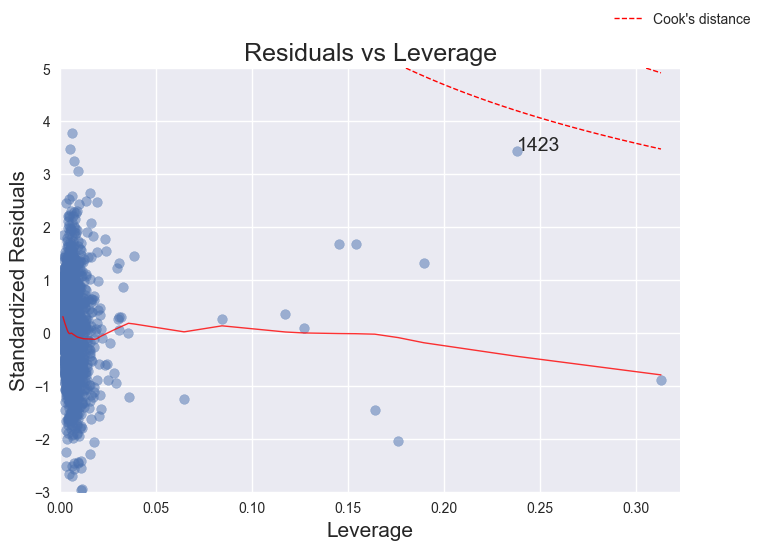

In [249]:
diagnostic_plots(sm.add_constant(X), y)

In [251]:
print(X[base].iloc[[523, 1298]])

      OverallQual  OverallCond  Neighborhood  GrLivArea  LotArea  YearBuilt  \
Id                                                                            
524            10            5     11.712321       4676    40094          0   
1299           10            5     11.712321       5642    63887          0   

      Foundation  TotRmsAbvGrd  GarageArea  PoolArea  
Id                                                    
524     12.26167     12.549248       884.0         0  
1299    12.26167     12.412001      1418.0       480  


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     891.6
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        14:54:42   Log-Likelihood:                 758.55
No. Observations:                1429   AIC:                            -1495.
Df Residuals:                    1418   BIC:                            -1437.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.1343      0.525     13.594   

C:\Users\david\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


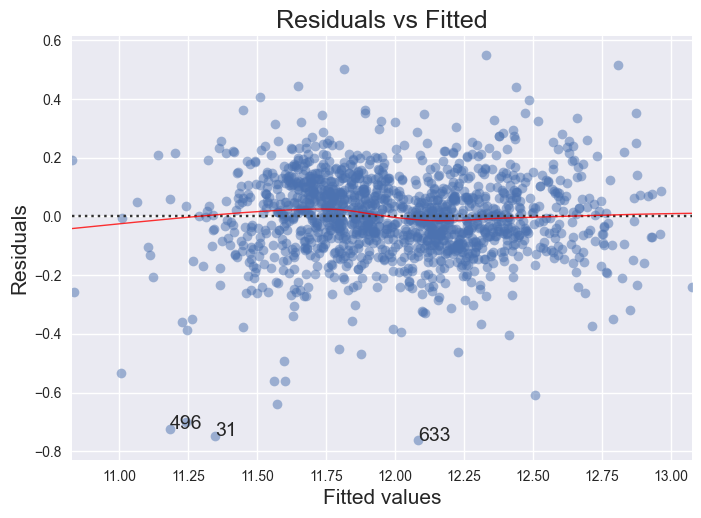

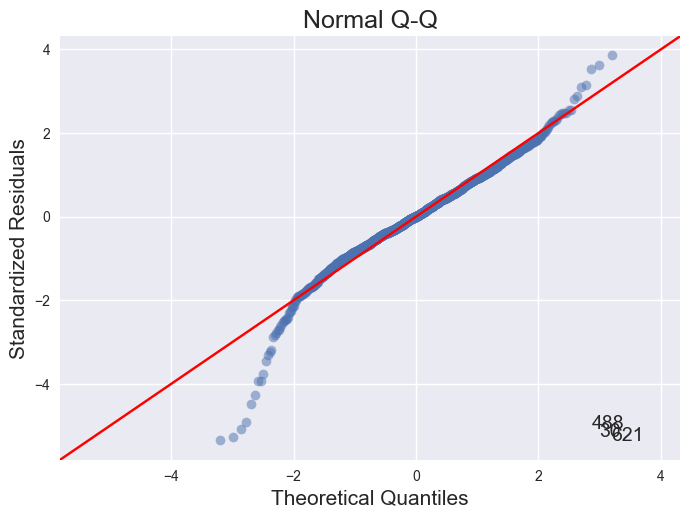

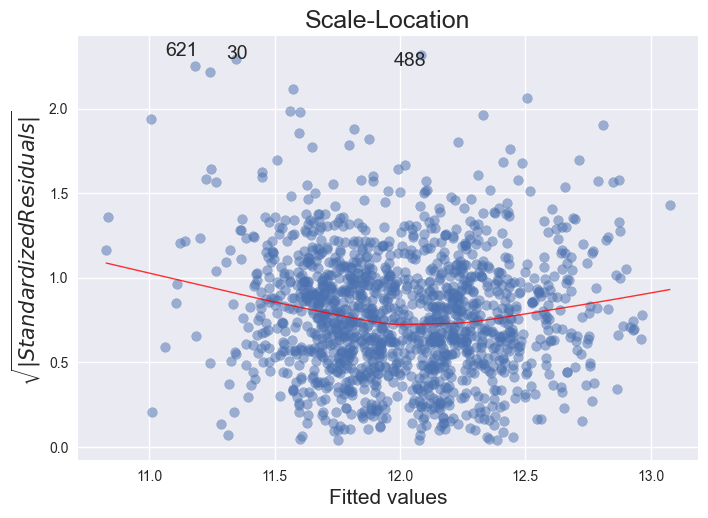

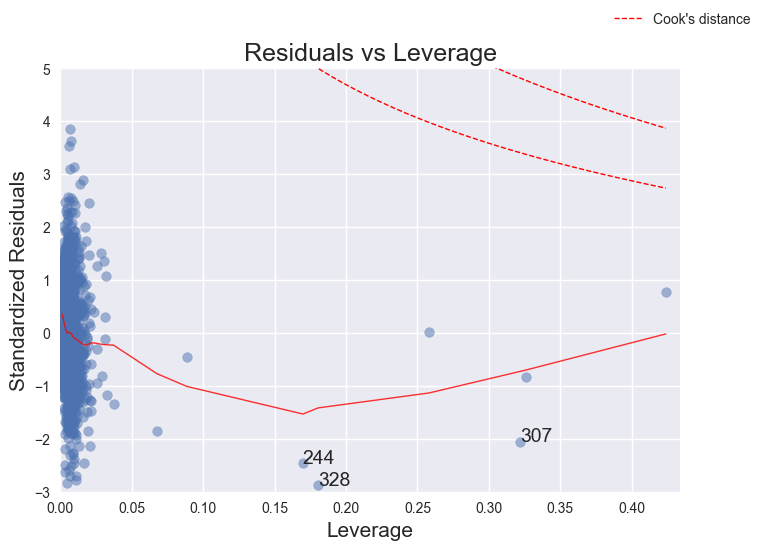

In [252]:
X, y = remove_outliers(X, y, feature = 'GrLivArea')

model = sm.OLS(y, sm.add_constant(X))
res = model.fit()

print(res.summary())

diagnostic_plots(sm.add_constant(X), y)

In [253]:
y_pred = res.predict(sm.add_constant(X))
print(y_pred.head())

Id
1    12.262324
2    12.161443
3    12.312840
4    12.033965
5    12.690637
dtype: float64


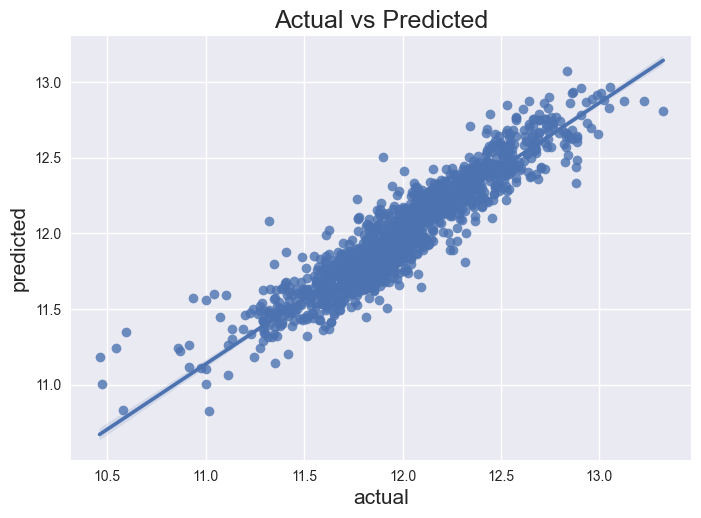

In [254]:
plot_prediction(y, y_pred)

In [255]:
print('Root Mean Square Error (RMSE) :', rmse(y, y_pred))

Root Mean Square Error (RMSE) : 0.14230717219635883


In [256]:
y_val = res.predict(sm.add_constant(X_val))

print(y_val.head())

Id
1461    11.777543
1462    11.873634
1463    12.068405
1464    12.178777
1465    12.271600
dtype: float64


In [ ]:
submission = pd.DataFrame()
submission['Id'] = y_val.index
submission['SalePrice'] = np.expm1(y_val.values)

submission.to_csv('correlation_linear_10_columns.csv', index = False)


### Model 2



### Model 3



### Model 4

